In [1]:
import numpy as np,  pandas as pd,  matplotlib.pyplot as plt, seaborn as sns
import datetime as dt 

import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pmdarima as pm 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.linear_model import LinearRegression 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

import joblib as jb

pd.options.display.float_format = '{:,.2f}'.format

import warnings 
warnings.filterwarnings('ignore')

## Data Processing

In [2]:
stocks = {}
stocks['FPT'] = pd.read_csv(r'C:\Users\user\Documents\python\Project Stock\Data\FPT Corp Stock Price History.csv', parse_dates=['Date'], index_col='Date')
stocks['HPG'] = pd.read_csv(r'C:\Users\user\Documents\python\Project Stock\Data\Hoa Phat Group JSC Stock Price History.csv', parse_dates=['Date'], index_col='Date')
stocks['MWG'] = pd.read_csv(r'C:\Users\user\Documents\python\Project Stock\Data\Mobile World Investment Corp Stock Price History.csv', parse_dates=['Date'], index_col='Date')
stocks['VNM'] = pd.read_csv(r'C:\Users\user\Documents\python\Project Stock\Data\Vinamilk Stock Price History.csv', parse_dates=['Date'], index_col='Date')
stocks['VCB'] = pd.read_csv(r'C:\Users\user\Documents\python\Project Stock\Data\Vietcombank Stock Price History.csv', parse_dates=['Date'], index_col='Date')

In [3]:
for key, value in stocks.items():
    print('Stock of:', key)
    print(value.info())
    print("="*30)

Stock of: FPT
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500 entries, 2024-12-31 to 2019-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1500 non-null   object
 1   Open      1500 non-null   object
 2   High      1500 non-null   object
 3   Low       1500 non-null   object
 4   Vol.      1500 non-null   object
 5   Change %  1500 non-null   object
dtypes: object(6)
memory usage: 82.0+ KB
None
Stock of: HPG
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500 entries, 2024-12-31 to 2019-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1500 non-null   object
 1   Open      1500 non-null   object
 2   High      1500 non-null   object
 3   Low       1500 non-null   object
 4   Vol.      1500 non-null   object
 5   Change %  1500 non-null   object
dtypes: object(6)
memory usage: 82.0+ KB
None
Stock of: MWG
<class 'pa

In [3]:
lst = ['Price', 'Open', 'High', 'Low']
for key, value in stocks.items():
    for col in lst:
        value[col] = value[col].str.replace(',', '').astype(float)
    value['Vol.'] = value['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').astype(float) 
    value['Change %'] = value['Change %'].str.replace('%', '').astype(float)
    stocks[key] = value.iloc[::-1]
    

## EDA

In [5]:
for key, value in stocks.items():
    print('Stock of:', key)
    print(value.describe())
    print("="*30)

Stock of: FPT
           Price       Open       High        Low          Vol.  Change %
count   1,500.00   1,500.00   1,500.00   1,500.00      1,500.00  1,500.00
mean   64,782.53  64,737.25  65,454.03  64,085.92  2,668,286.75      0.14
std    31,742.04  31,719.00  32,050.19  31,419.19  1,799,044.96      1.76
min    21,270.30  21,166.00  21,609.10  21,113.90    246,980.00    -15.31
25%    34,292.10  34,232.60  34,575.43  33,992.95  1,440,000.00     -0.64
50%    62,925.50  62,924.50  63,394.00  62,029.00  2,230,000.00      0.11
75%    79,317.00  79,263.00  80,176.00  78,515.75  3,380,000.00      0.95
max   152,500.00 151,900.00 153,900.00 150,400.00 15,380,000.00      7.00
Stock of: HPG
          Price      Open      High       Low           Vol.  Change %
count  1,500.00  1,500.00  1,500.00  1,500.00       1,500.00  1,500.00
mean  21,899.43 21,918.24 22,203.28 21,632.77  25,324,626.67      0.08
std    9,154.78  9,180.51  9,279.59  9,066.30  14,560,952.04      2.15
min    7,411.80  7,000

1. **FPT**:

- Biến động mạnh: Giá có độ lệch chuẩn cao (31,742), phạm vi giá rộng (21,270 - 152,500), phản ánh rủi ro/tiềm năng tăng trưởng lớn.
- Thanh khoản trung bình (2.6 triệu CP/phiên), nhưng có phiên đột biến lên 15.3 triệu CP.
- Thay đổi giá hàng ngày dao động mạnh (-15.31% đến +7%), phù hợp với nhà đầu tư mạo hiểm.

2. HPG:

- Thanh khoản cao nhất (25.3 triệu CP/phiên), phù hợp giao dịch ngắn hạn.
- Giá ổn định hơn FPT (std ~9,154) nhưng vẫn có biến động âm sâu (-7%), vì liên quan đến ngành chu kỳ thép
- Phân phối giá tương đối đối xứng (median ≈ mean).

3. MWG:

- Biến động trung bình (std ~14,422), phạm vi giá 19,198 - 79,582.
- Khối lượng giao dịch tăng mạnh ở phân vị 75 (5.39 triệu CP), cho thấy sự quan tâm tăng trong giai đoạn tăng giá.
- Phù hợp chiến lược trung hạn, kết hợp tăng trưởng và ổn định.

4. VNM:

- Ổn định hơn (std ~14,875), giá dao động chủ yếu quanh 58k - 118k.
- Thay đổi giá trung bình âm nhẹ (-0.02%), có thể phản ánh áp lực bán trong giai đoạn phân tích.
- Phù hợp đầu tư dài hạn, ít rủi ro nhờ ngành tiêu dùng thiết yếu.

5. VCB:

- Rủi ro đặc thù: Dù std thấp (~13,183), có phiên giảm sâu -14.92%, do yếu tố ngành ngân hàng (lãi suất, nợ xấu).
- Thanh khoản thấp nhất (1.38 triệu CP/phiên), cần cân nhắc khi vào/lệnh lớn.
- Median giá ~74,980, gần mean, phân phối cân bằng.

Tổng thể:

- Rủi ro: FPT > HPG > MWG > VCB > VNM.
- Thanh khoản: HPG > MWG > FPT > VNM > VCB.

=> Chiến lược: FPT/HPG phù hợp lướt sóng; VNM/VCB hợp đầu tư giá trị; MWG cân bằng giữa hai nhóm. Cần theo dõi yếu tố vĩ mô và ngành để tối ưu hóa danh mục.

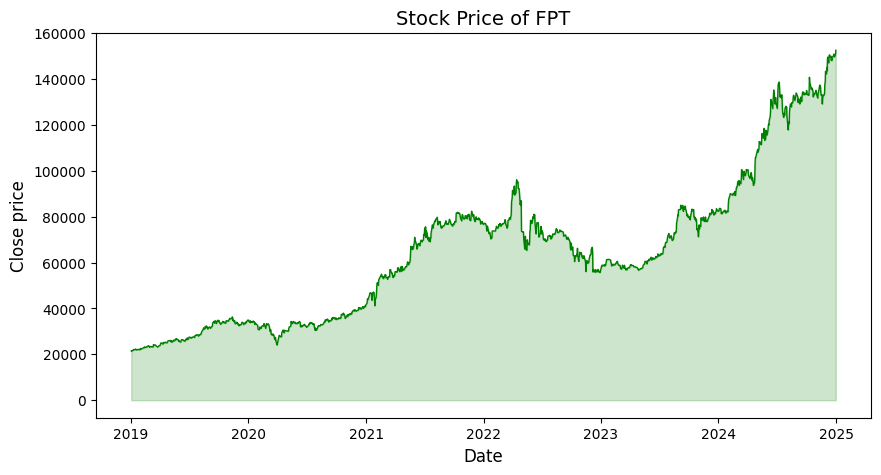

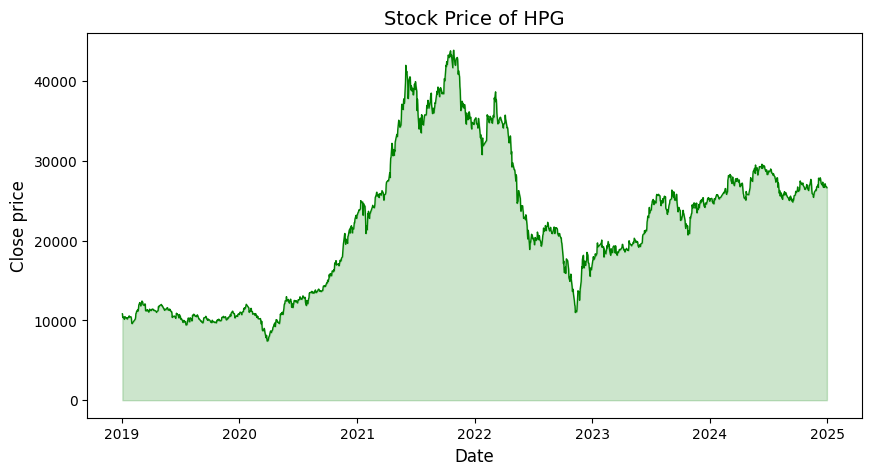

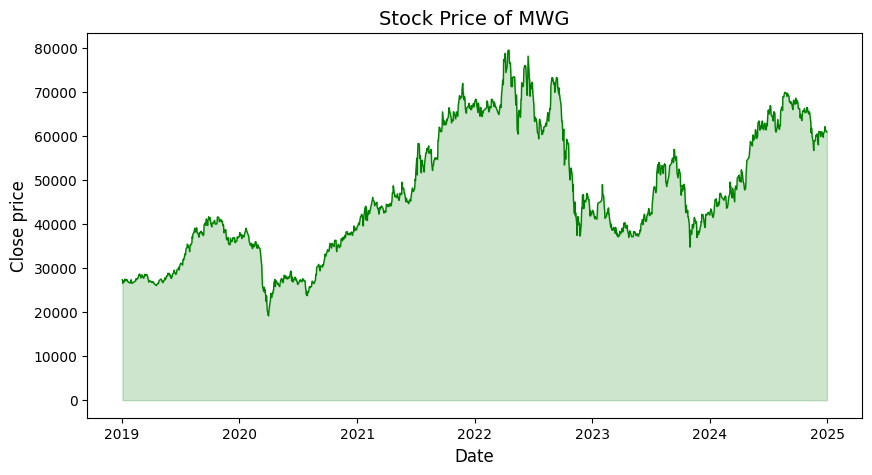

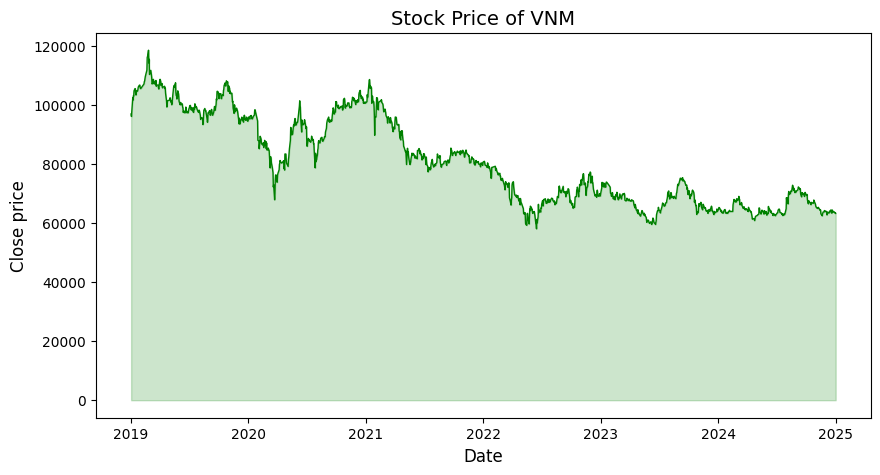

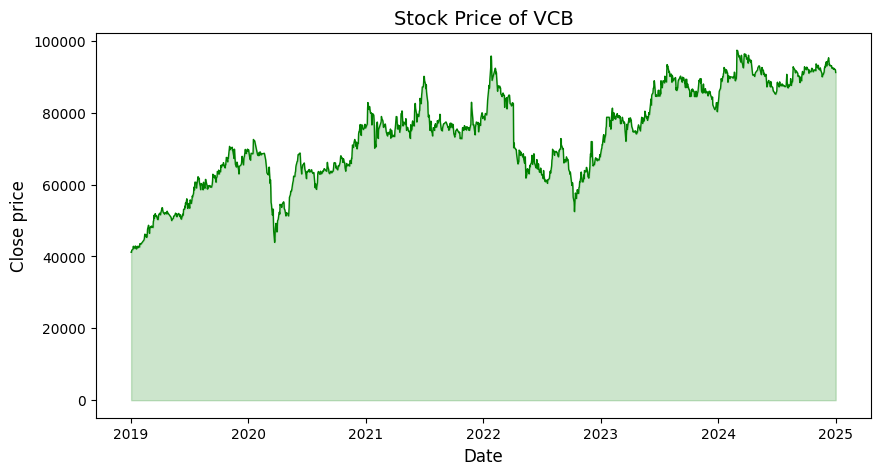

In [12]:
# chart_dict = {}
for company, data in stocks.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data['Price'], color='green', linewidth=1)

    ax.fill_between(data.index, data['Price'], alpha=0.2, color='green')

    ax.set_title(f"Stock Price of {company}", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Close price", fontsize=12)
    plt.savefig(f"C:/Users/user/Documents/python/Project Stock/Photos/{company}_price.png", format='png')
    # chart_dict[company] = fig
    
# jb.dump(chart_dict, r"C:\Users\user\Documents\python\Project Stock\chart.pkl")

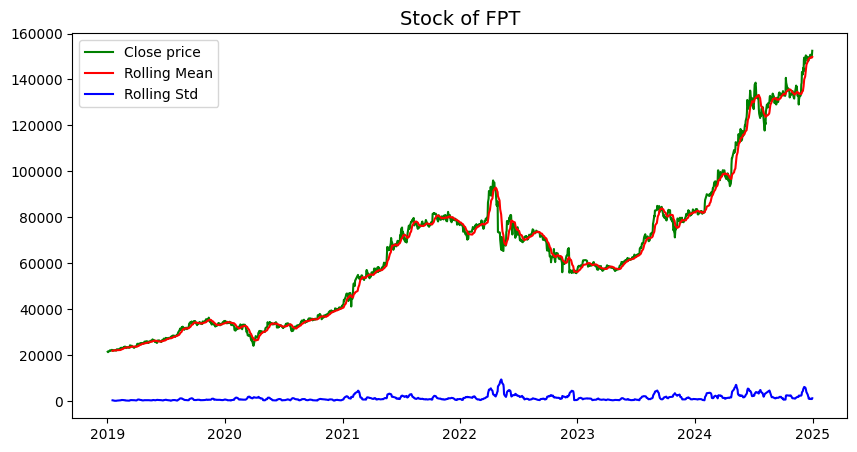

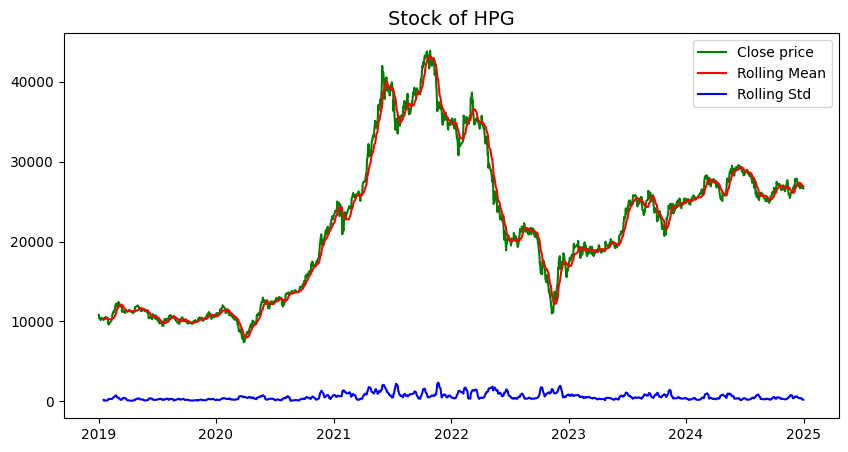

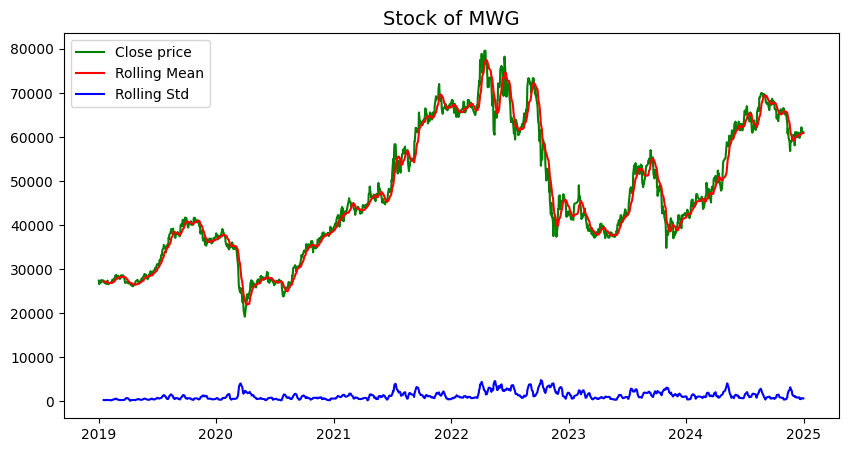

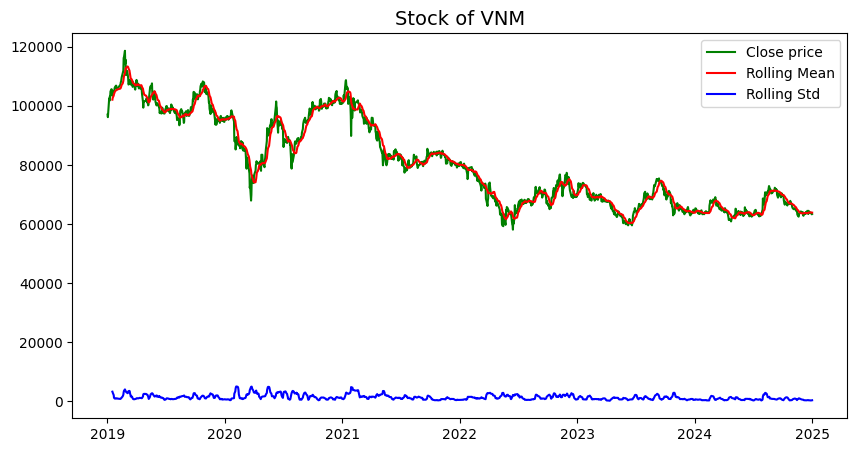

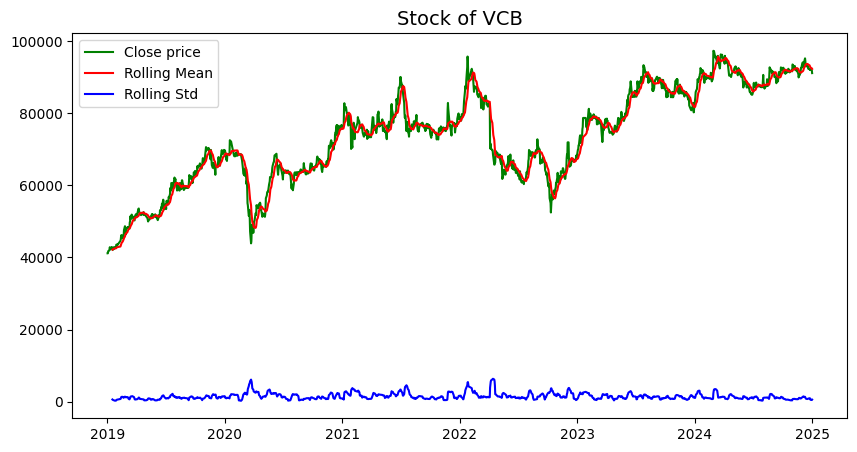

In [13]:
# chart_rolling = {}
for key, value in stocks.items():
    rolling_mean = value['Price'].rolling(window=12).mean()
    rolling_std = value['Price'].rolling(window=12).std()
    price = value['Price']
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(price, color='green', label='Close price')
    ax.plot(rolling_mean, color='red', label='Rolling Mean')
    ax.plot(rolling_std, color='blue', label='Rolling Std')
    
    ax.set_title(f'Stock of {key}', fontsize=14)
    ax.legend()
    plt.savefig(f"C:/Users/user/Documents/python/Project Stock/Photos/{key}_rolling.png", format='png')
    # chart_rolling[key] = fig
    
# jb.dump(chart_rolling, r"C:\Users\user\Documents\python\Project Stock\chart_rolling.pkl")

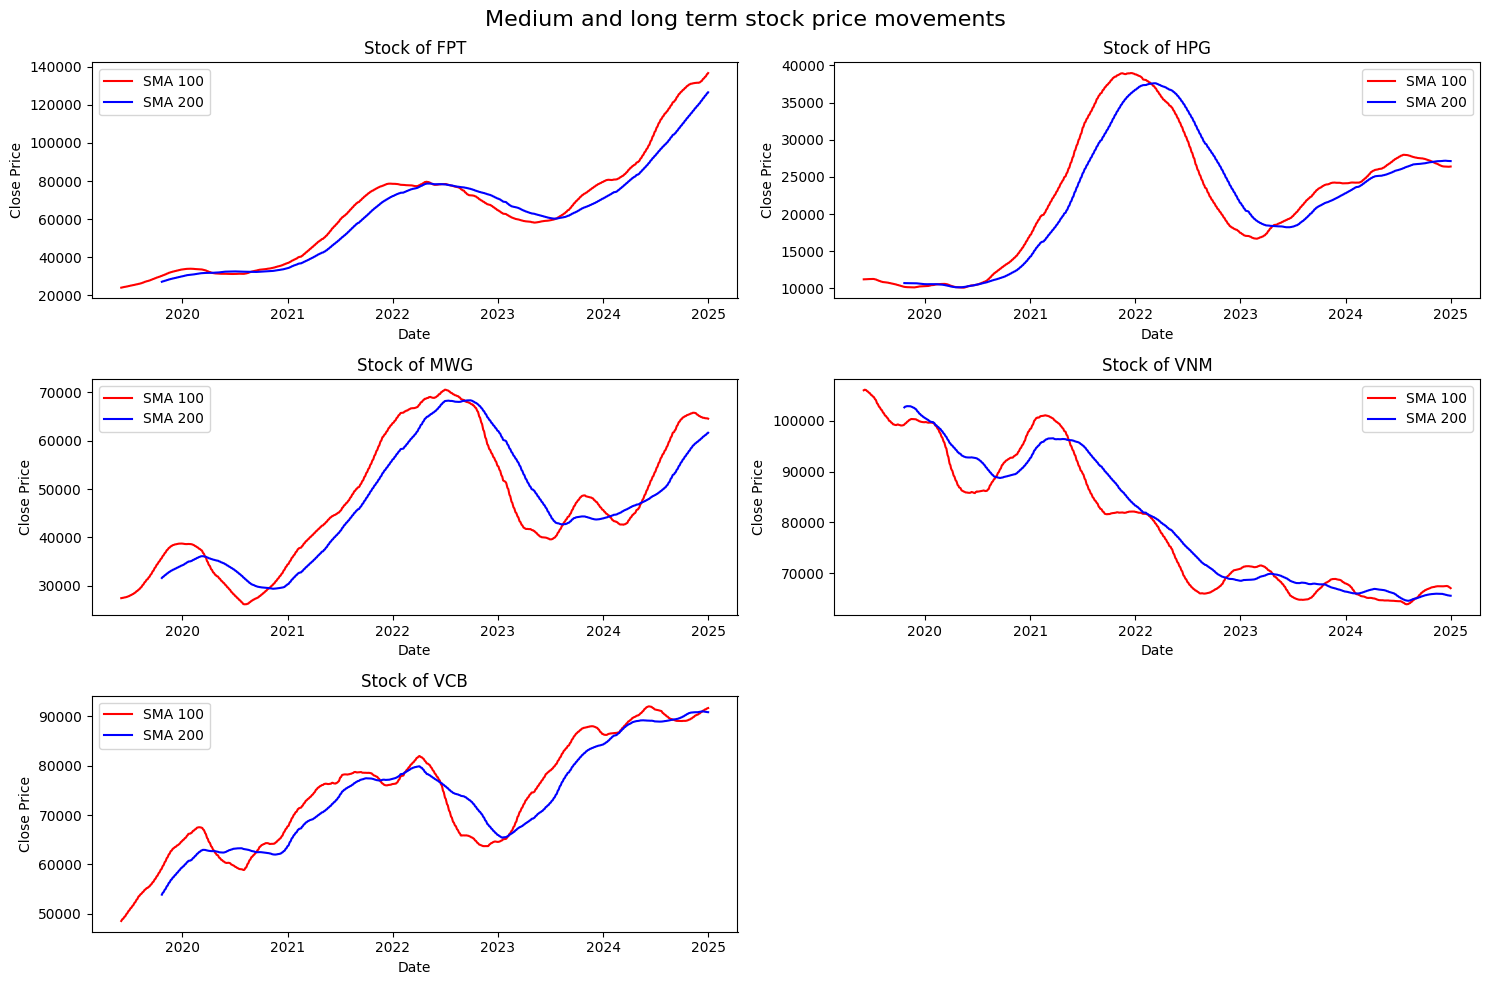

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, (key, value) in enumerate(stocks.items()):
    ax = axes[idx]
    SMA_100 = value['Price'].rolling(window=100).mean()
    SMA_200 = value['Price'].rolling(window=200).mean()
    ax.plot(SMA_100, color='red', label='SMA 100')
    ax.plot(SMA_200, color='blue', label='SMA 200')
    ax.set_title(f'Stock of {key}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend()
for ax in axes[len(stocks):]:
    ax.remove()
fig.suptitle("Medium and long term stock price movements", fontsize=16)    

plt.tight_layout()
plt.show()

1. FPT:

- Xu hướng tăng mạnh (2020–2023): Giá tăng từ ~40,000 lên đỉnh 140,000 (2023), phản ánh tăng trưởng vượt trội.
- Dấu hiệu điều chỉnh (2023–2025): Giá giảm nhẹ sau đỉnh, nhưng SMA 100 vẫn duy trì trên SMA 200, cho thấy xu hướng tăng còn tiềm năng.

2. HPG:

- Biến động mạnh: Giá tăng từ ~10,000 (2020) lên 40,000 (2023), sau đó giảm về 25,000 (2025).
- Tín hiệu SMA: SMA 100 cắt xuống dưới SMA 200 (2024), xác nhận xu hướng giảm.

3. MWG:

- Tăng trưởng ổn định: Giá tăng đều từ ~20,000 (2020) lên 70,000 (2025), SMA 100 luôn trên SMA 200.
- Triển vọng: Xu hướng tăng được củng cố, phù hợp đầu tư trung/dài hạn.

4. VNM:

- Tăng nhẹ nhưng thiếu đột phá: Giá tăng từ 70,000 lên 100,000 (2023), sau đó đi ngang.
- SMA phẳng: SMA 100 và SMA 200 giao động sát nhau, phản ánh thị trường sideway.

5. VCB:

- Xu hướng tăng vững: Giá tăng từ 50,000 (2020) lên 90,000 (2025), SMA 100 duy trì trên SMA 200.
- Rủi ro tiềm ẩn: Biến động lãi suất và nợ xấu có thể ảnh hưởng ngắn hạn.

## Linear Regression

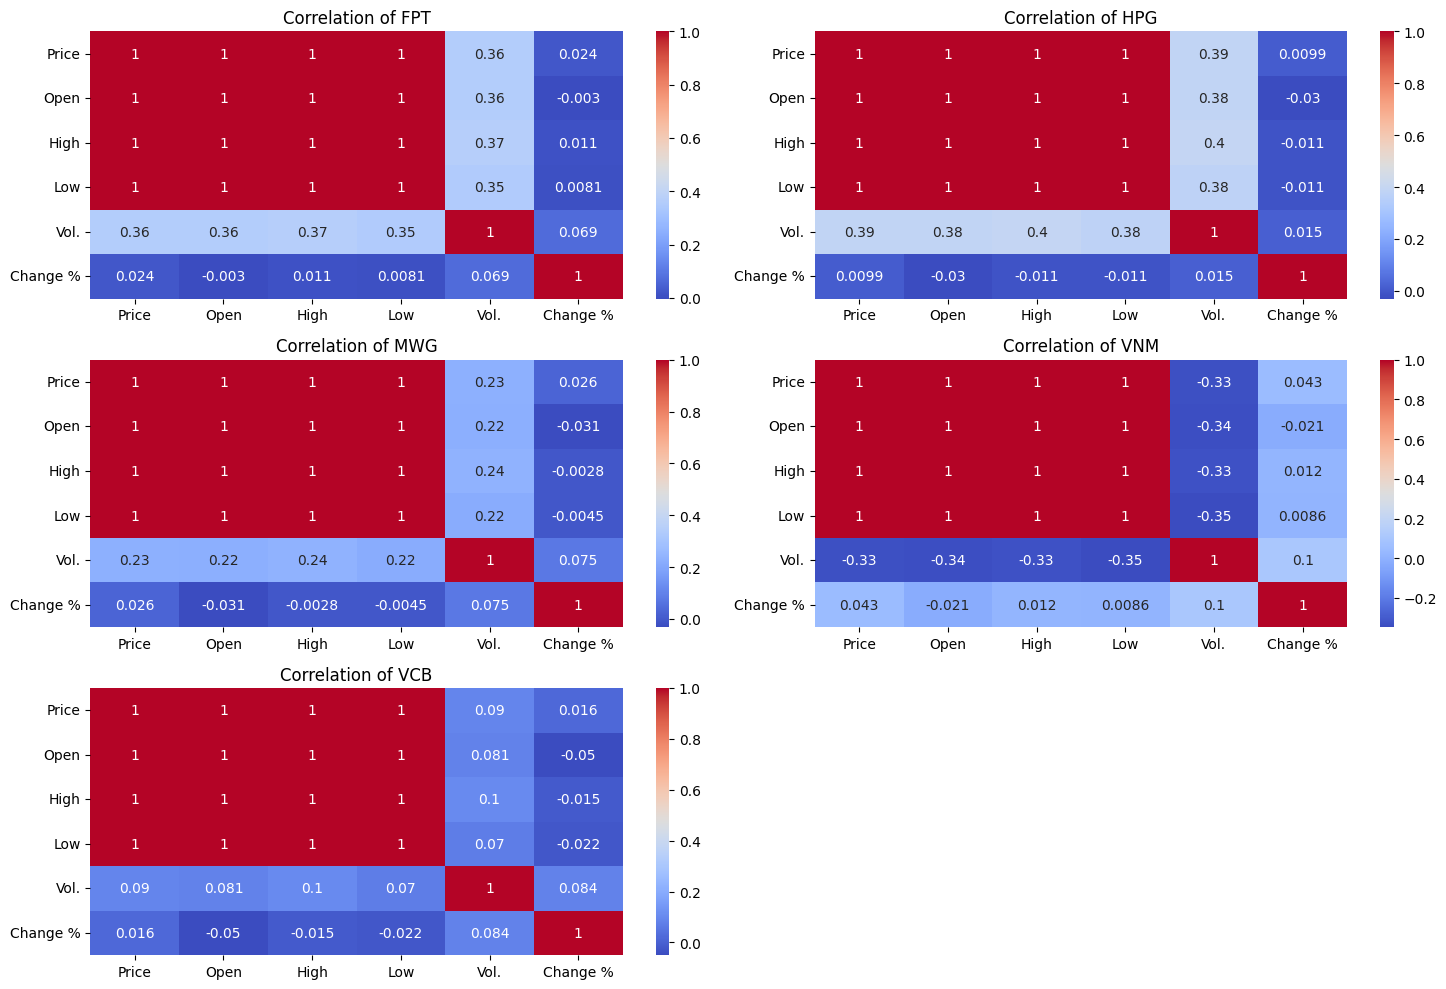

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, (key, value) in enumerate(stocks.items()):
    ax = axes[idx]
    sns.heatmap(value.corr(), annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(f'Correlation of {key}')
for ax in axes[len(stocks):]:
    ax.remove()
plt.tight_layout()
plt.show()

In [5]:
def psar(df, af=0.02, af_max=0.2):
    high, low = df["High"].values, df["Low"].values
    psar = np.zeros(len(df))
    trend = 1  
    ep = low[0]  
    af_step = af  

    for i in range(1, len(df)):
        psar[i] = psar[i - 1] + af_step * (ep - psar[i - 1])

        if trend == 1:
            if low[i] < psar[i]:  
                trend = -1
                psar[i] = ep
                af_step = af
                ep = high[i]
            else:
                if high[i] > ep:
                    ep = high[i]
                    af_step = min(af_step + af, af_max)
        else:
            if high[i] > psar[i]:  
                trend = 1
                psar[i] = ep
                af_step = af
                ep = low[i]
            else:
                if low[i] < ep:
                    ep = low[i]
                    af_step = min(af_step + af, af_max)

    df["PSAR"] = psar
    return df


In [6]:
def cal_tech_indicators(stocks):
    for company, data in stocks.items():
        short_ema = data["Price"].ewm(span=12, adjust=False).mean()
        long_ema = data["Price"].ewm(span=26, adjust=False).mean()
        data["MACD"] = short_ema - long_ema
        data["Signal_Line"] = data["MACD"].ewm(span=9, adjust=False).mean()
        
        window_length = 14
        close_delta = data["Price"].diff()

        gain = close_delta.where(close_delta > 0, 0)
        loss = -close_delta.where(close_delta < 0, 0)

        avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
        avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

        rs = avg_gain / avg_loss
        data["RSI"] = 100 - (100 / (1 + rs))
        
        data["OBV"] = (data["Vol."] * (~data["Price"].diff().lt(0) * 2 - 1)).cumsum()

        data = psar(data)
        
        data["SMA_10"] = data["Price"].rolling(window=10).mean()
        data["SMA_50"] = data["Price"].rolling(window=50).mean()
        data["EMA_50"] = data["Price"].ewm(span=50, adjust=False).mean()
        data["Target"] = data["Price"].shift(-1)
        
        data = data.dropna()
        stocks[company] = data

In [7]:
cal_tech_indicators(stocks)

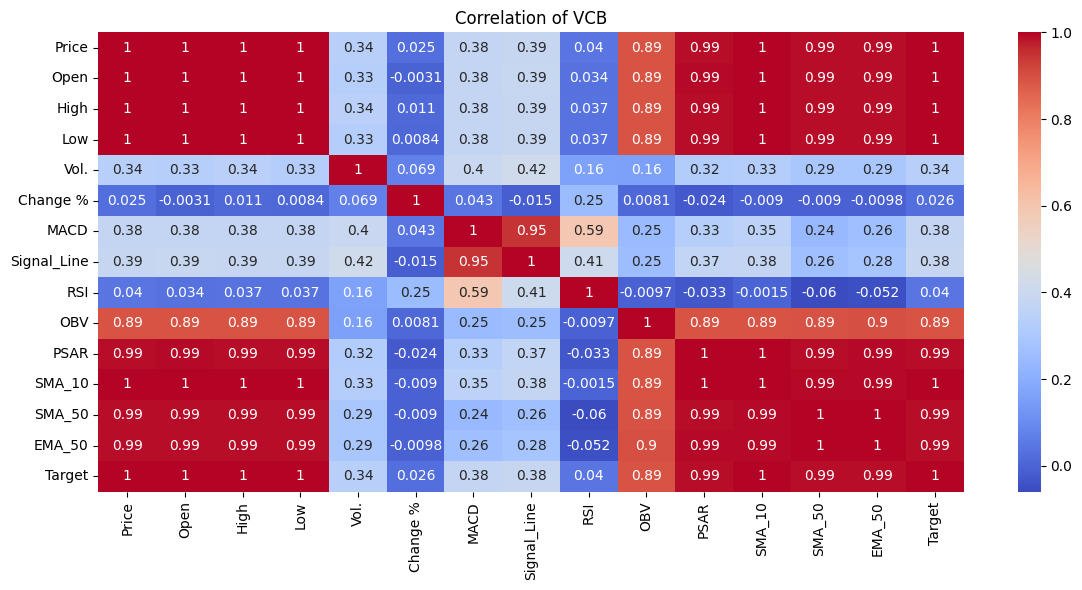

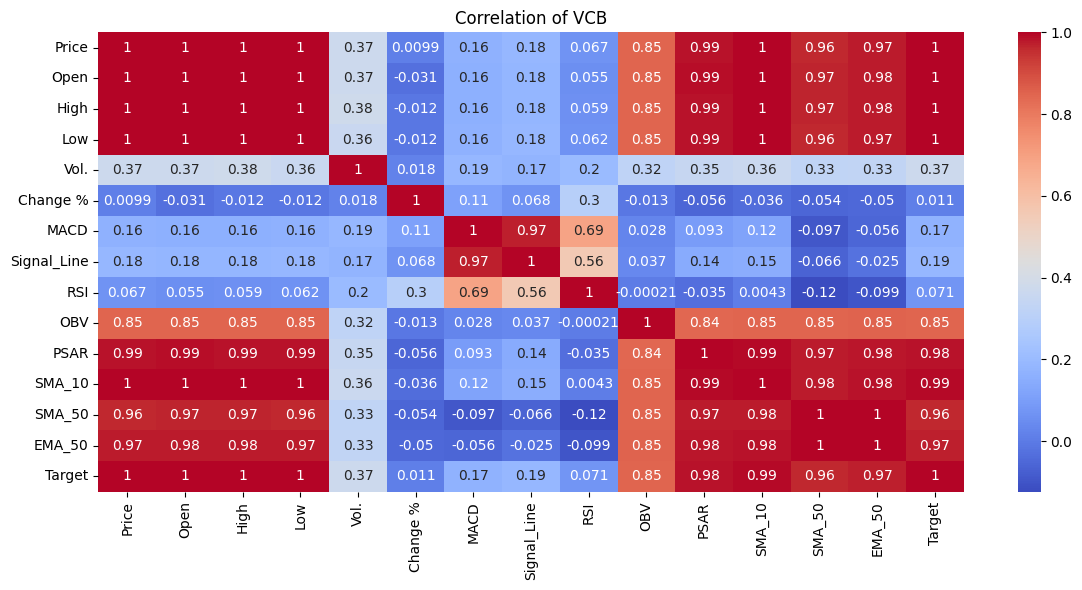

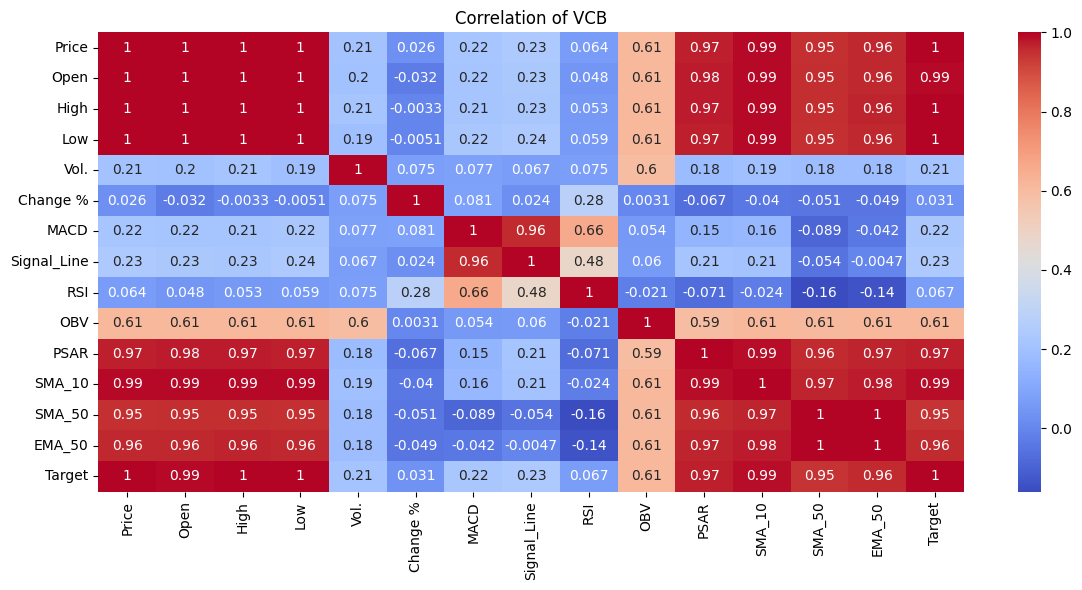

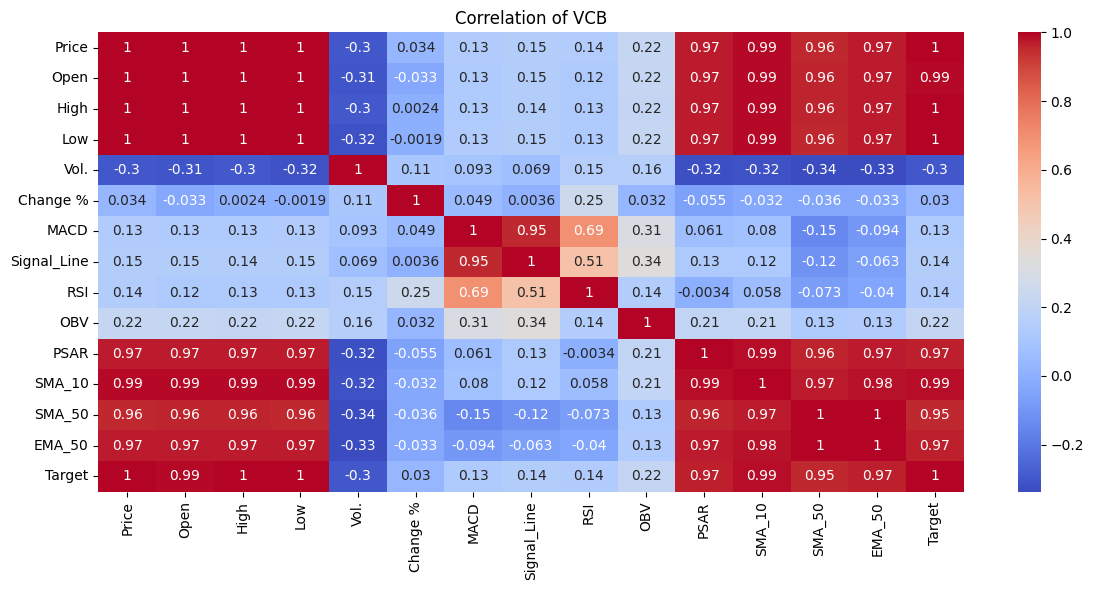

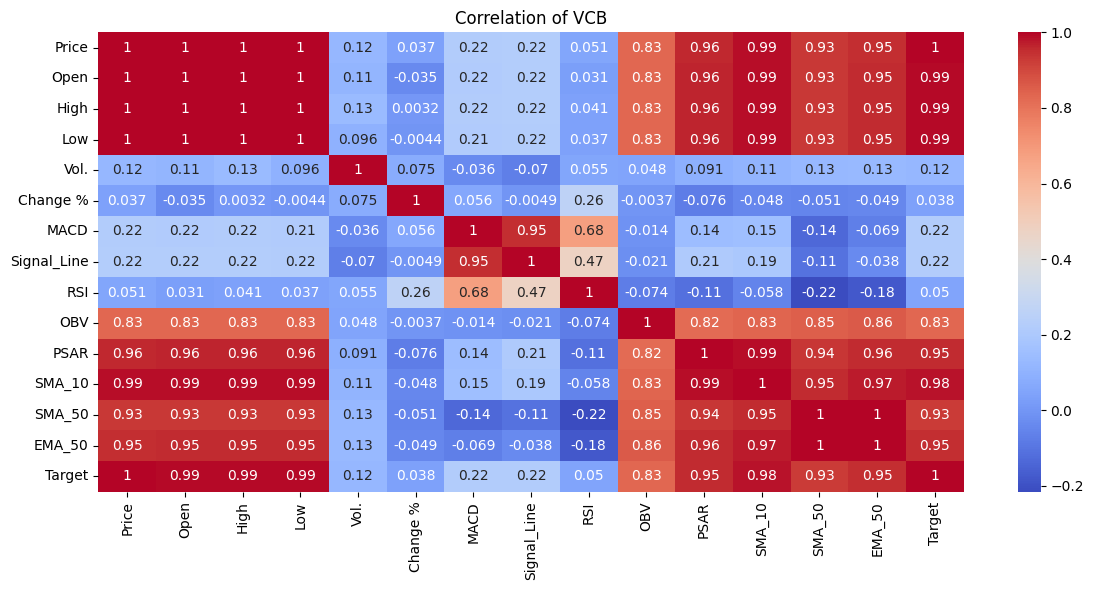

In [ ]:
for company, data in stocks.items():
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation of {key}')
    plt.tight_layout()
    plt.show()

In [15]:
# def VIF(stock):
#     for company, data in stock.items():
#         X = data.drop(columns=['Target', 'Price'])
#         vif_data = pd.DataFrame()
#         vif_data['Variable'] = X.columns
#         vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#         print(f"Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu {company}:")
#         print(vif_data.sort_values(by='VIF',ascending=False))
# VIF(stocks)

In [11]:
def training_linear_regression(data, features, scaler=None):
    X = data[features]
    y = data["Target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = LinearRegression()
        model.fit(X_train, y_train)
    else:
        model = LinearRegression()
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results = {
        "model": model,
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
        'Predict': y_pred,
        'Actual': y_test 
    }

    return results

In [48]:
def test_scaler(data):
    scalers = {
        'Not scaled': None,
        'Standard Scaler': StandardScaler(),
        'MinMax Scaler': MinMaxScaler(),
        'Robust Scaler': RobustScaler()
    }
    results = {}
    features = ['Change %', 'MACD', 'RSI', 'OBV',
            'PSAR', 'SMA_10', 'SMA_50', 'EMA_50']
    for scaler_name, scaler in scalers.items():
        metrics = training_linear_regression(data, features, scaler)
        results[scaler_name] = [metrics['MSE'], metrics['MAE'], metrics['R2']]
    return results

In [49]:
stocks_copy = stocks.copy()
for company, data in stocks_copy.items():
    print(f"Results for {company}")
    result = test_scaler(data)
    result_df = pd.DataFrame(result, index=['MSE', 'MAE', 'R2'])   
    print(result_df.T)

Results for FPT
                         MSE      MAE   R2
Not scaled      4,781,263.68 1,571.77 0.99
Standard Scaler 4,781,263.68 1,571.77 0.99
MinMax Scaler   4,781,263.68 1,571.77 0.99
Robust Scaler   4,781,263.68 1,571.77 0.99
Results for HPG
                       MSE    MAE   R2
Not scaled      186,616.88 334.35 0.91
Standard Scaler 186,616.88 334.35 0.91
MinMax Scaler   186,616.88 334.35 0.91
Robust Scaler   186,616.88 334.35 0.91
Results for MWG
                         MSE    MAE   R2
Not scaled      1,356,319.13 911.57 0.99
Standard Scaler 1,356,319.13 911.57 0.99
MinMax Scaler   1,356,319.13 911.57 0.99
Robust Scaler   1,356,319.13 911.57 0.99
Results for VNM
                       MSE    MAE   R2
Not scaled      798,150.70 675.26 0.88
Standard Scaler 798,150.70 675.26 0.88
MinMax Scaler   798,150.70 675.26 0.88
Robust Scaler   798,150.70 675.26 0.88
Results for VCB
                         MSE    MAE   R2
Not scaled      1,258,875.38 838.10 0.89
Standard Scaler 1,258,875.38

In [14]:
features = ['Change %', 'MACD', 'RSI', 'OBV',
            'PSAR', 'SMA_10', 'SMA_50', 'EMA_50']
results = {}
for company, data in stocks.items():
    results[company] = training_linear_regression(data=data, features=features)

results_df = pd.DataFrame(results).T
print(results_df[['MSE', 'MAE', 'R2']])

             MSE      MAE   R2
FPT 4,781,263.68 1,571.77 0.99
HPG   186,616.88   334.35 0.91
MWG 1,356,319.13   911.57 0.99
VNM   798,150.70   675.26 0.88
VCB 1,258,875.38   838.10 0.89


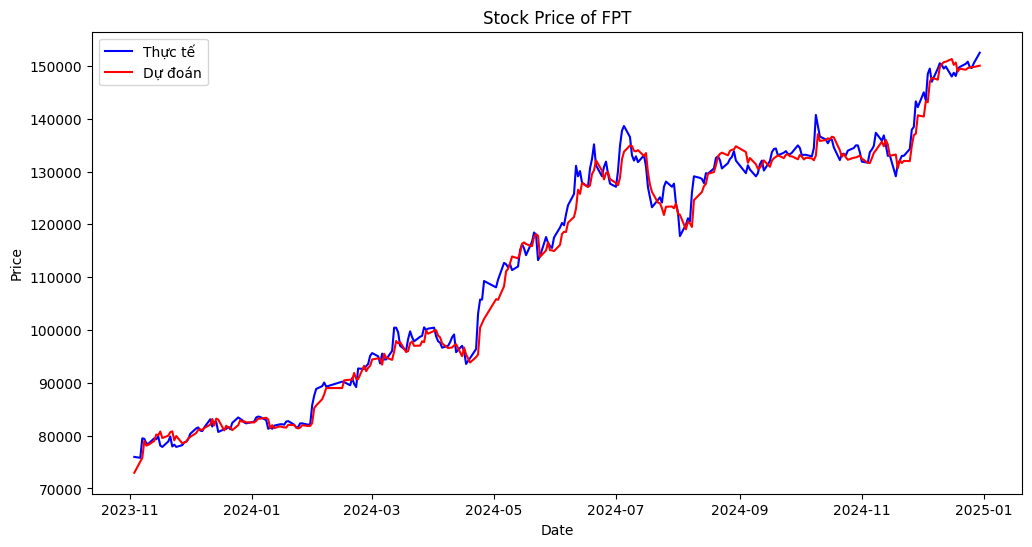

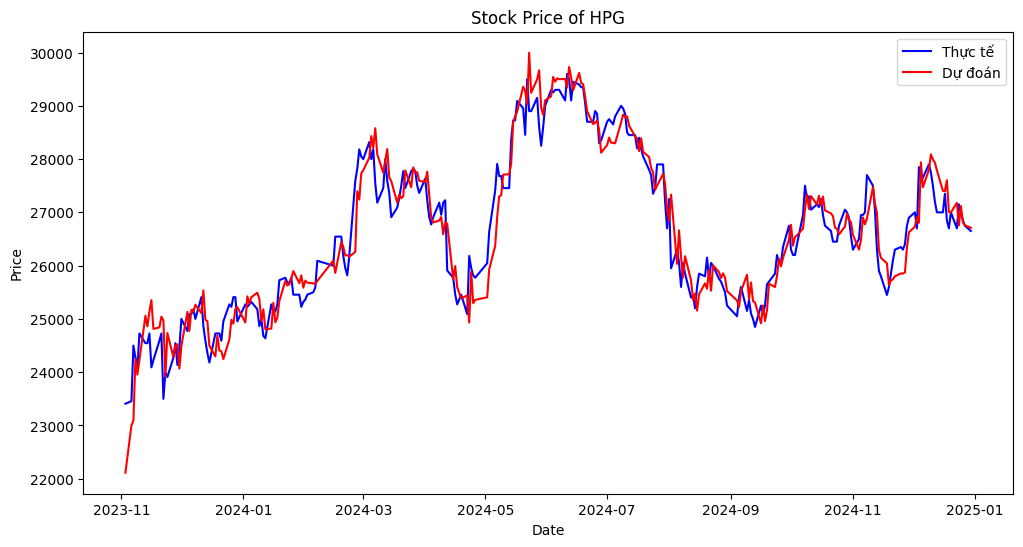

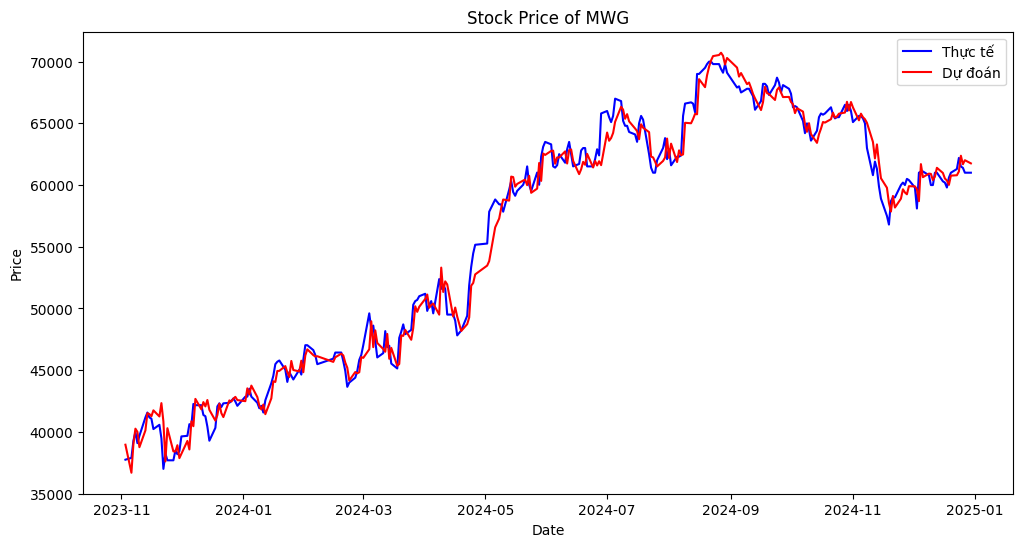

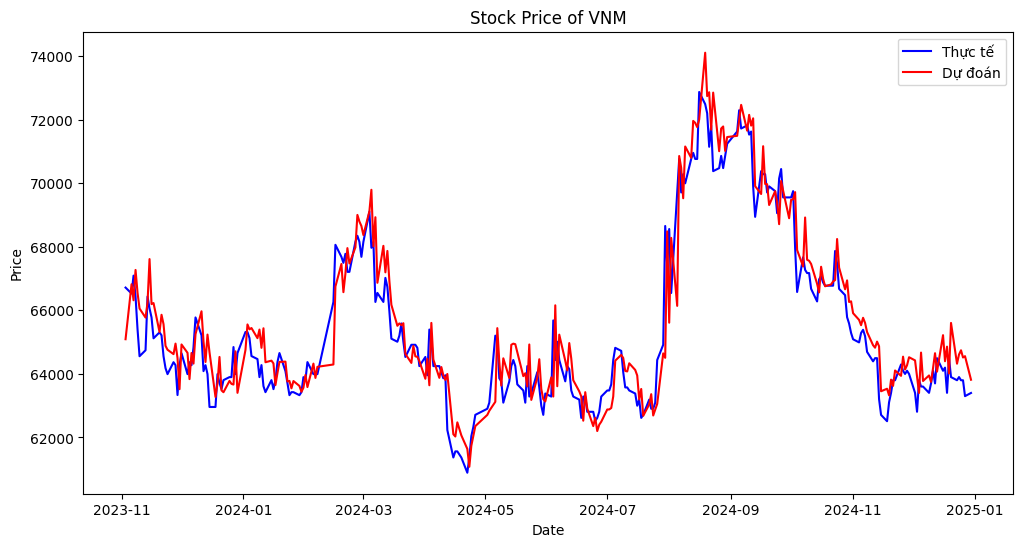

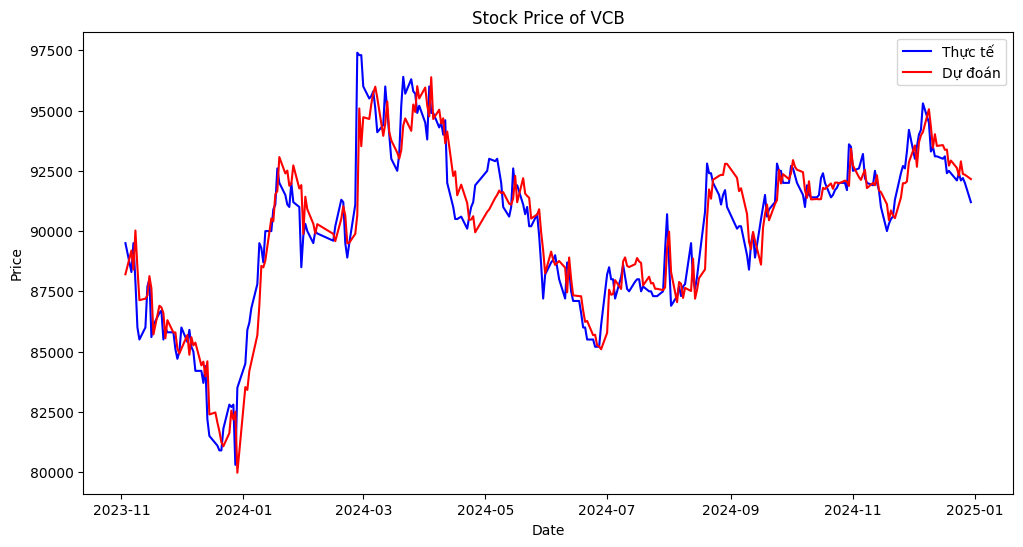

In [16]:
for company, data in results.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Actual'].index, data["Actual"], label="Thực tế", color="blue")
    plt.plot(data['Actual'].index, data["Predict"], label="Dự đoán", color="red")
    plt.legend()
    plt.title(f"Stock Price of {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()  

## ARIMA

Stock of: FPT


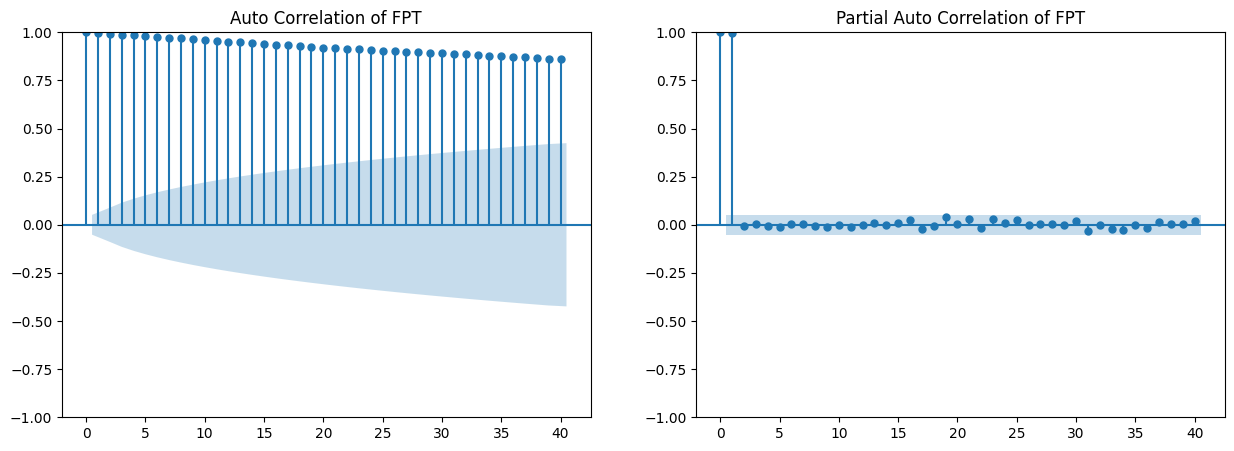

Stock of: HPG


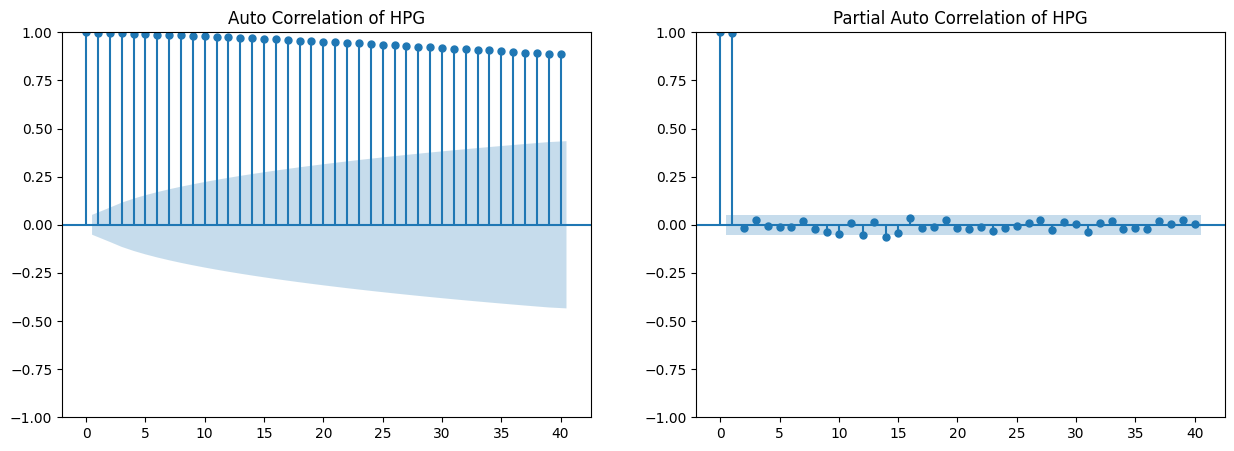

Stock of: MWG


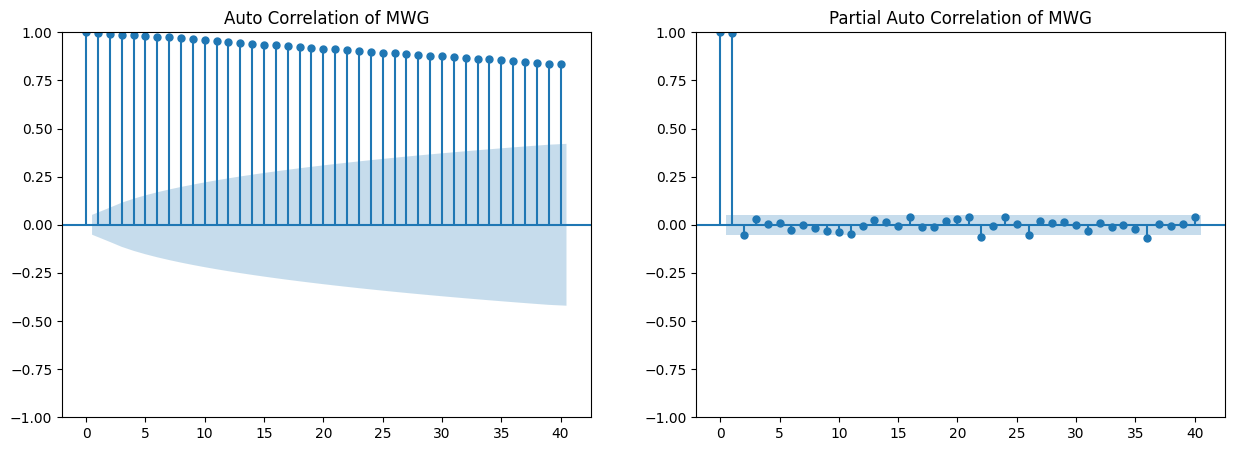

Stock of: VNM


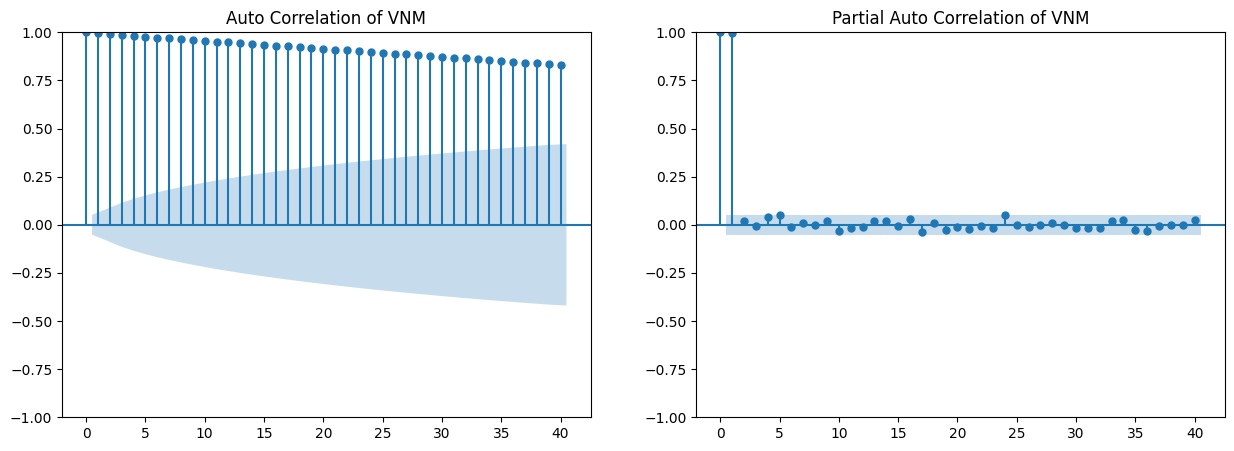

Stock of: VCB


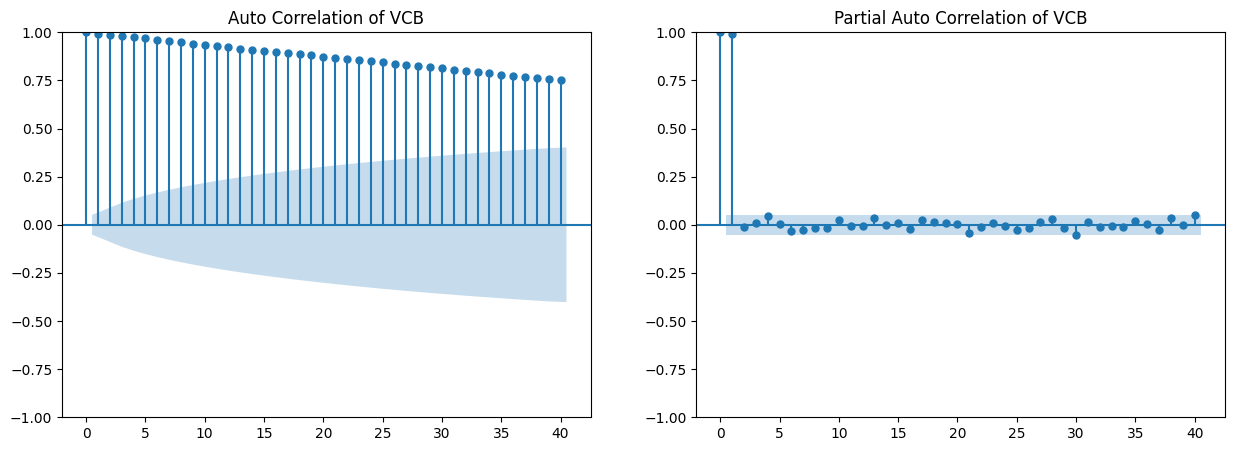

In [52]:
for key, value in stocks.items():
    print('Stock of:', key)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(value['Price'], ax=ax[0], lags=40)
    ax[0].set_title(f'Auto Correlation of {key}')
    plot_pacf(value['Price'], ax=ax[1], lags=40)
    ax[1].set_title(f'Partial Auto Correlation of {key}')
    plt.show()

In [53]:
def adf_test(x):
    adf = adfuller(x)
    indices = ['Test statistic', 'p-value', '# of logs used', '# of Observation']
    results = pd.Series(adf[0:4], index=indices)
    for key, value in adf[4].items():
        results[f'Critical Value {key}'] = value
    return results 

def kpss_test(x):
    kpss_ = kpss(x)
    indices = ['Test statistic', 'p-value', '# of logs used']
    results = pd.Series(kpss_[0:3], index=indices)
    for key, value in kpss_[3].items():
        results[f'Critical Value {key}'] = value
    return results
        
def stationary_test(x):
    adf_result = adf_test(x)
    kpss_result = kpss_test(x)
    print(f'ADF test: \n{adf_result}')
    print(f'KPSS test \n{kpss_result}')
    if (adf_result['p-value'] <= 0.05) & (kpss_result['p-value'] > 0.05):
        print('=> Stationary')
    else:
        print('=> Not Stationary')

In [54]:
for company, data in stocks.items():
    print(f'Stock of {company}')
    stationary_test(data['Price'])
    print('='*30)

Stock of FPT
ADF test: 
Test statistic           1.38
p-value                  1.00
# of logs used          19.00
# of Observation     1,430.00
Critical Value 1%       -3.43
Critical Value 5%       -2.86
Critical Value 10%      -2.57
dtype: float64
KPSS test 
Test statistic         4.28
p-value                0.01
# of logs used        25.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74
dtype: float64
=> Not Stationary
Stock of HPG
ADF test: 
Test statistic          -1.56
p-value                  0.50
# of logs used          15.00
# of Observation     1,434.00
Critical Value 1%       -3.43
Critical Value 5%       -2.86
Critical Value 10%      -2.57
dtype: float64
KPSS test 
Test statistic         1.77
p-value                0.01
# of logs used        25.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74
dtype: float64
=> Not Stationary
Stock of MWG
ADF test:

In [55]:
for company, data in stocks.items():
    stocks[company]['Price diff'] = data['Price'].diff()
    stocks[company].dropna(inplace=True)

In [56]:
for company, data in stocks.items():
    print(f'Stock of {company}')
    stationary_test(data['Price diff'])
    print('='*30)

Stock of FPT
ADF test: 
Test statistic          -9.99
p-value                  0.00
# of logs used          18.00
# of Observation     1,430.00
Critical Value 1%       -3.43
Critical Value 5%       -2.86
Critical Value 10%      -2.57
dtype: float64
KPSS test 
Test statistic        0.32
p-value               0.10
# of logs used        3.00
Critical Value 10%    0.35
Critical Value 5%     0.46
Critical Value 2.5%   0.57
Critical Value 1%     0.74
dtype: float64
=> Stationary
Stock of HPG
ADF test: 
Test statistic          -8.17
p-value                  0.00
# of logs used          14.00
# of Observation     1,434.00
Critical Value 1%       -3.43
Critical Value 5%       -2.86
Critical Value 10%      -2.57
dtype: float64
KPSS test 
Test statistic        0.21
p-value               0.10
# of logs used        3.00
Critical Value 10%    0.35
Critical Value 5%     0.46
Critical Value 2.5%   0.57
Critical Value 1%     0.74
dtype: float64
=> Stationary
Stock of MWG
ADF test: 
Test statistic      

Stock of VCB


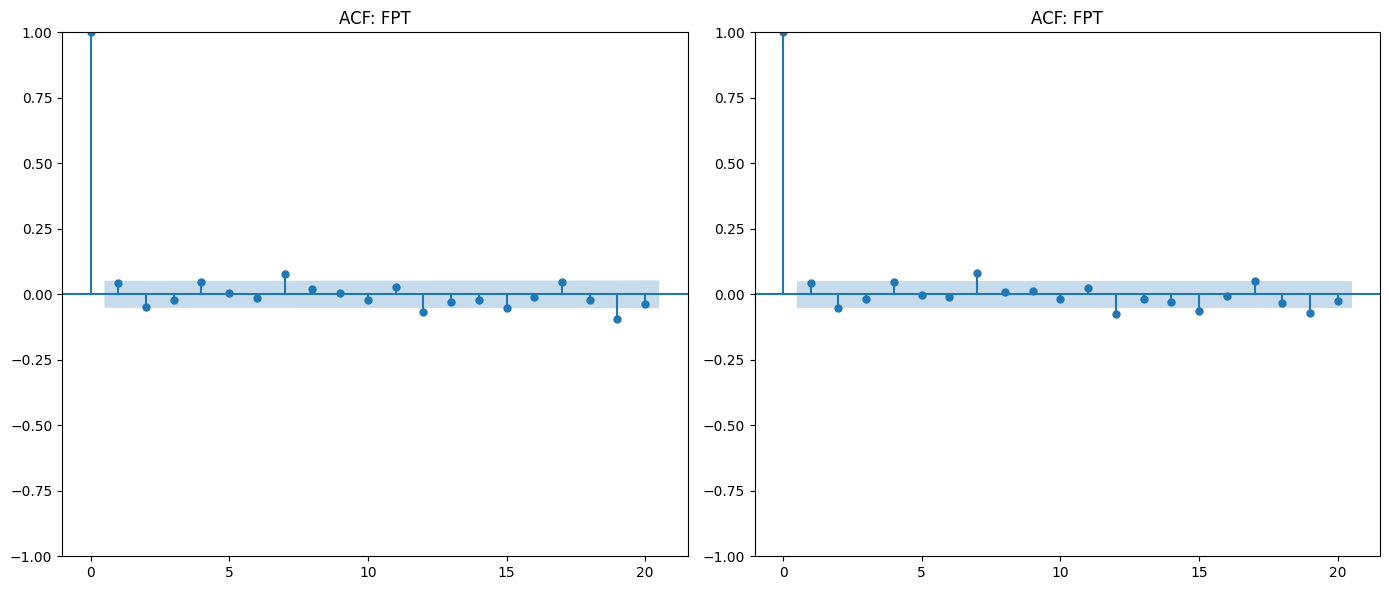

Stock of VCB


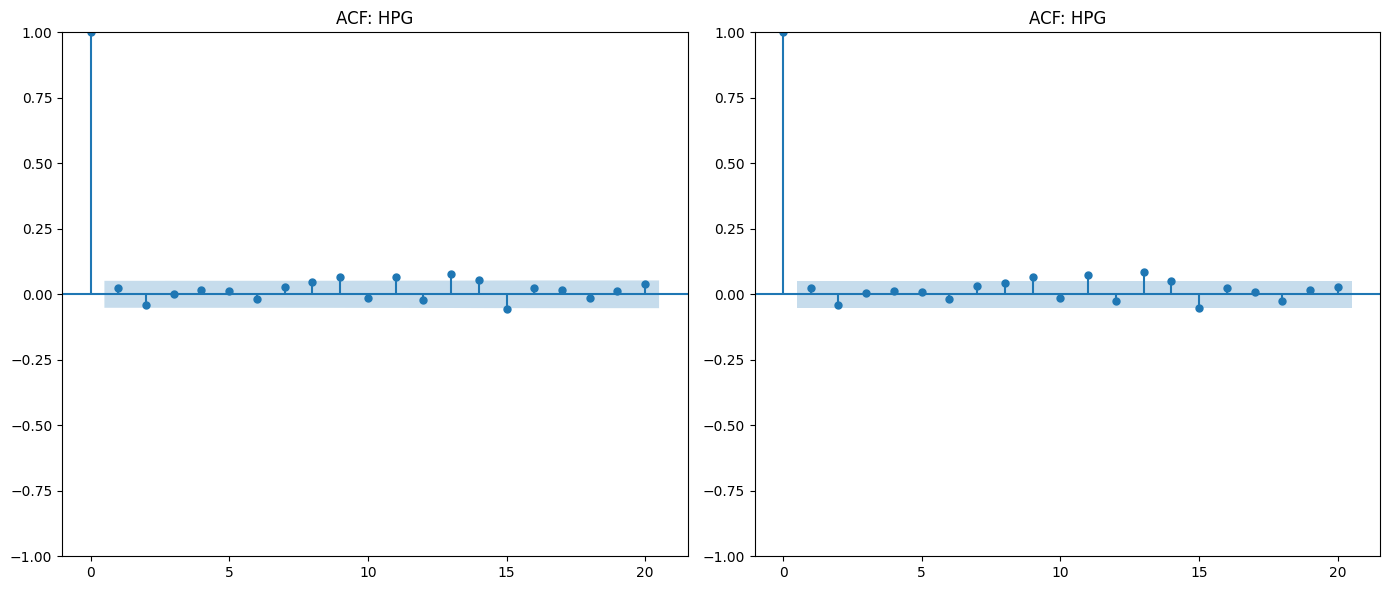

Stock of VCB


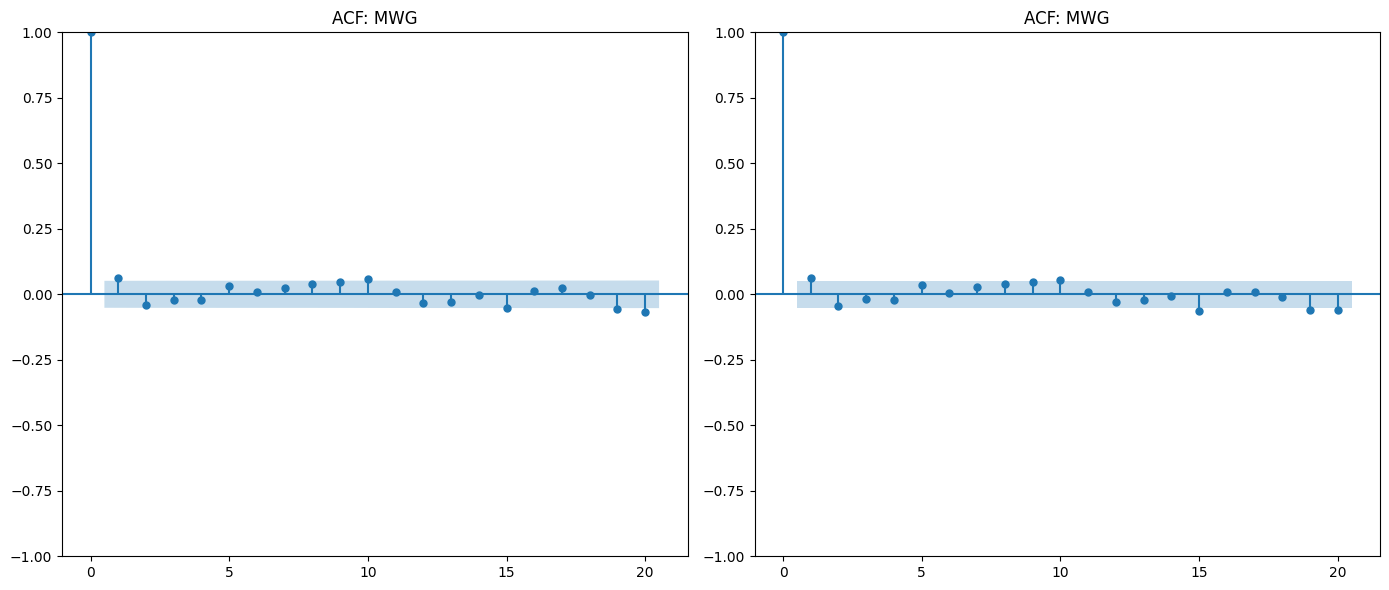

Stock of VCB


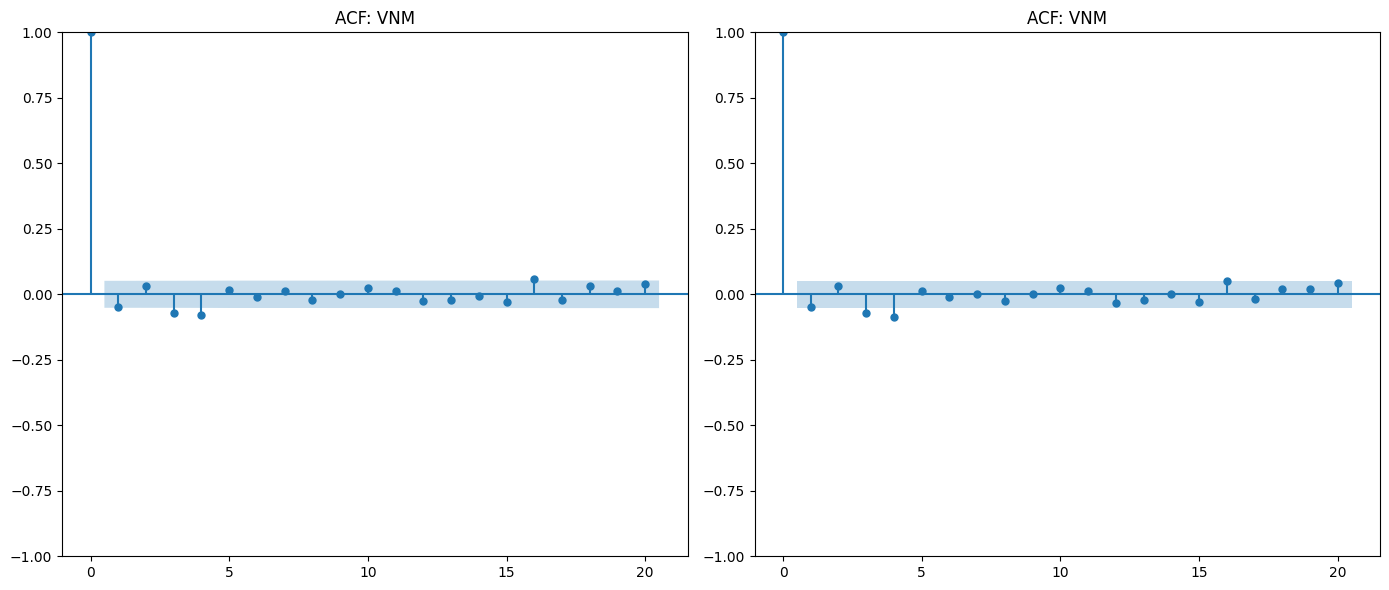

Stock of VCB


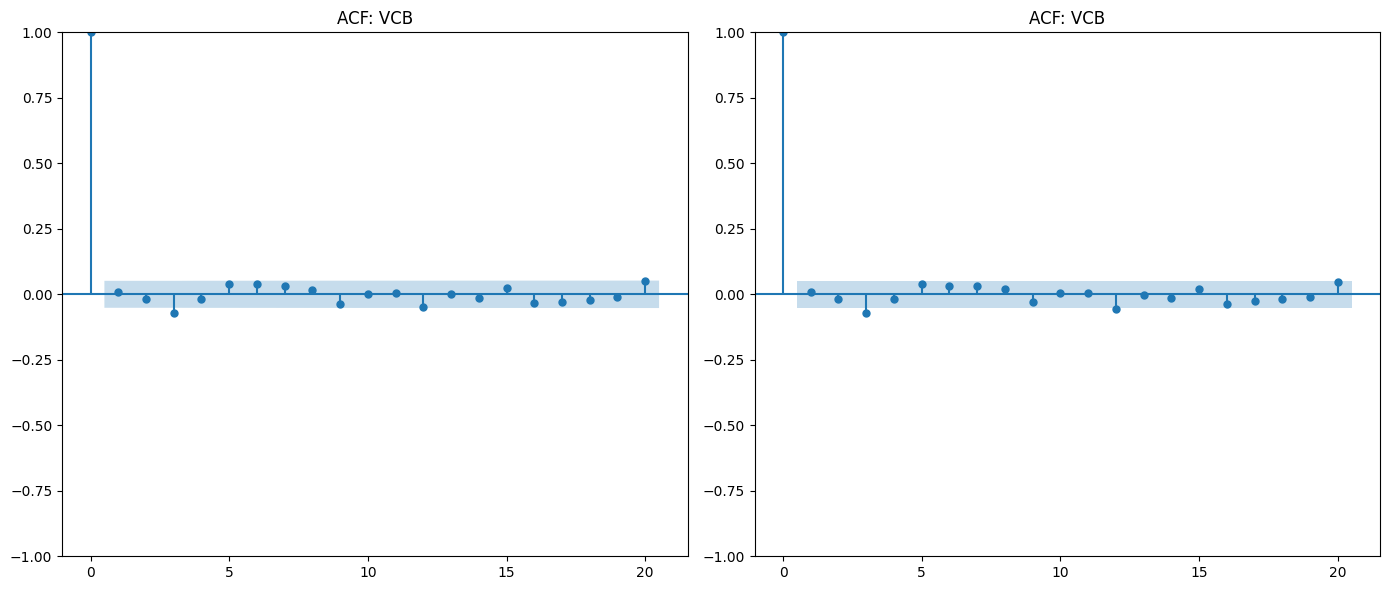

In [57]:
for company, data in stocks.items():
    print(f'Stock of {key}')
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    plot_acf(data['Price diff'], ax=ax[0], lags=20)
    ax[0].set_title(f"ACF: {company}")

    plot_pacf(data['Price diff'], ax=ax[1], lags=20)
    ax[1].set_title(f"ACF: {company}")
    
    plt.tight_layout()
    plt.show()

In [59]:
def training_arima(data):
    size = int(len(data) * 0.8)
    train, test = data[:size], data[size:]
    
    auto_arima = pm.auto_arima(train, trace=1, error_action='ignore', 
                               suppress_warning=True, seasonal=False, 
                               stepwise=True, approximation=False, n_jobs=1,
                                   seasonal_test=None)
    print(auto_arima.summary())
    
    y_pred = auto_arima.predict(n_periods = len(test))
    fig = plt.figure(figsize=(16, 12))
    auto_arima.plot_diagnostics(fig=fig, lags=40)
    plt.show()
    
    mae = mean_absolute_error(test, y_pred)
    mse = mean_squared_error(test, y_pred)
    r2 = r2_score(test, y_pred)
    
    return [auto_arima, mse, mae, r2]

Stock of FPT
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19820.859, Time=3.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19824.073, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19826.064, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19826.068, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19829.039, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19828.892, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=4.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19822.892, Time=3.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19828.064, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19828.243, Time=2.90 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19827.778, Time=0.66 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19824.855, Time=2.46 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19822.181, Time=2.21 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 19.253 seconds
 

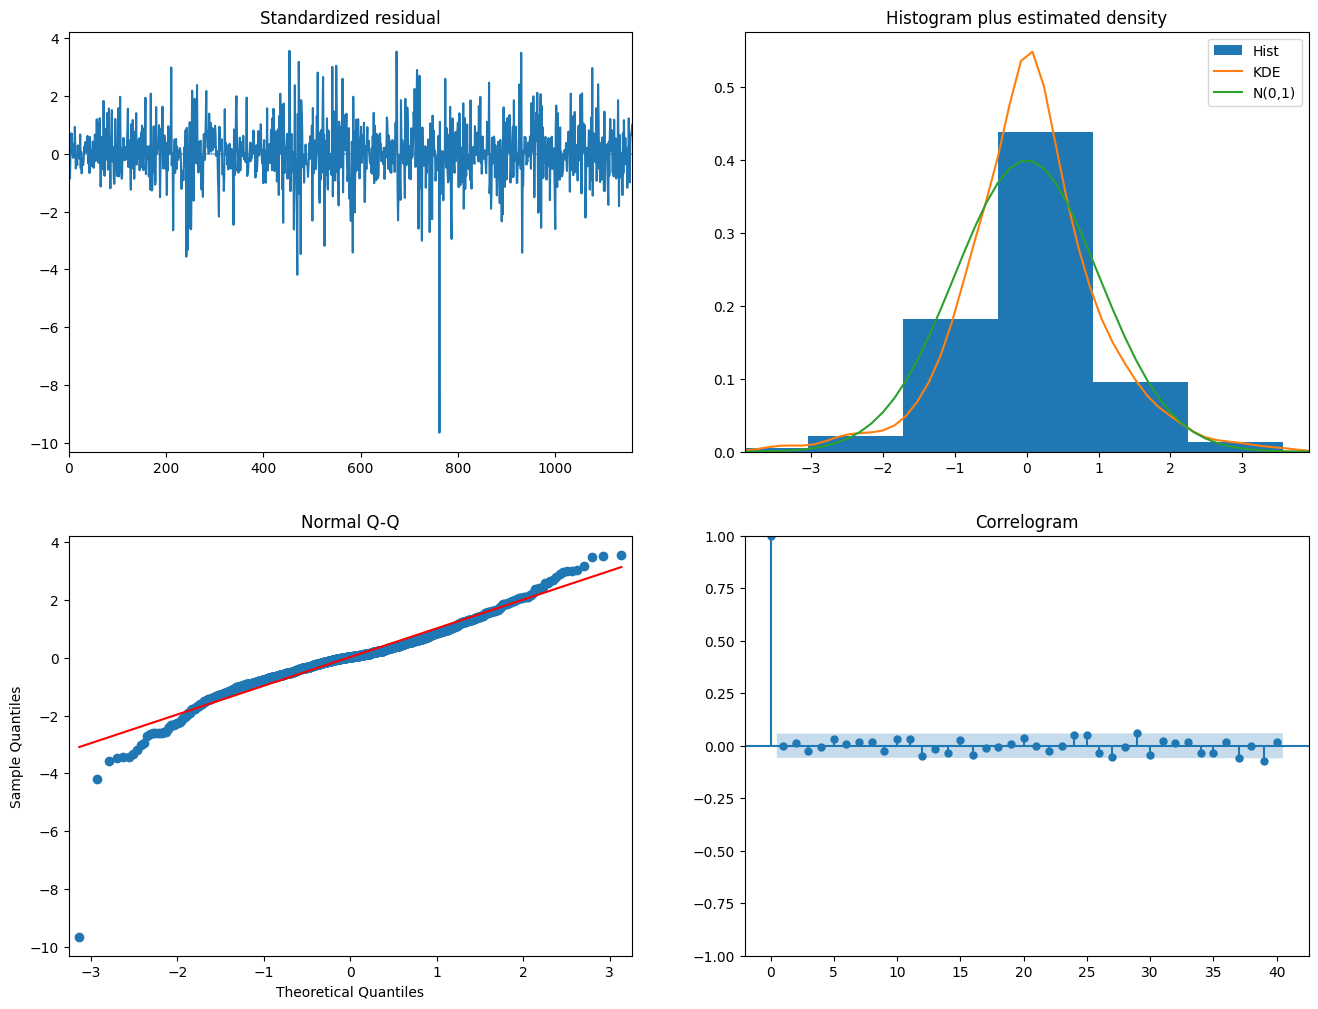

Stock of HPG
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19820.859, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19824.073, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19826.064, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19826.068, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19829.039, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19828.892, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.69 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19822.892, Time=2.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19828.064, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19828.243, Time=0.80 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19827.778, Time=0.30 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19824.855, Time=1.25 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19822.181, Time=2.30 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 12.099 seconds
 

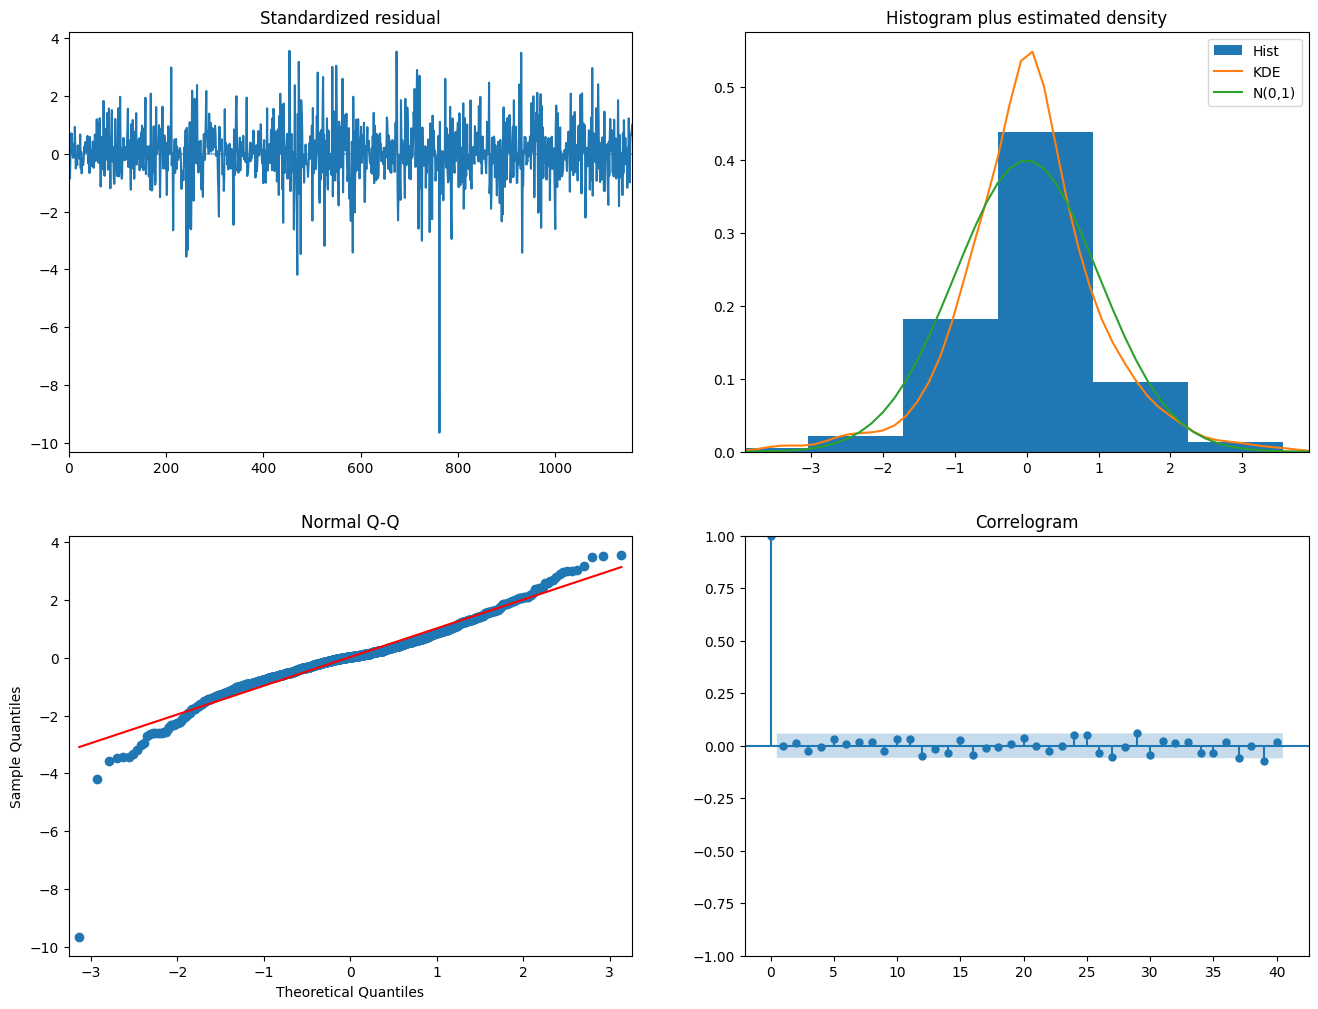

Stock of MWG
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19820.859, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19824.073, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19826.064, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19826.068, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19829.039, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19828.892, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19822.892, Time=1.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19828.064, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19828.243, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19827.778, Time=0.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19824.855, Time=0.95 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19822.181, Time=2.34 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 10.560 seconds
 

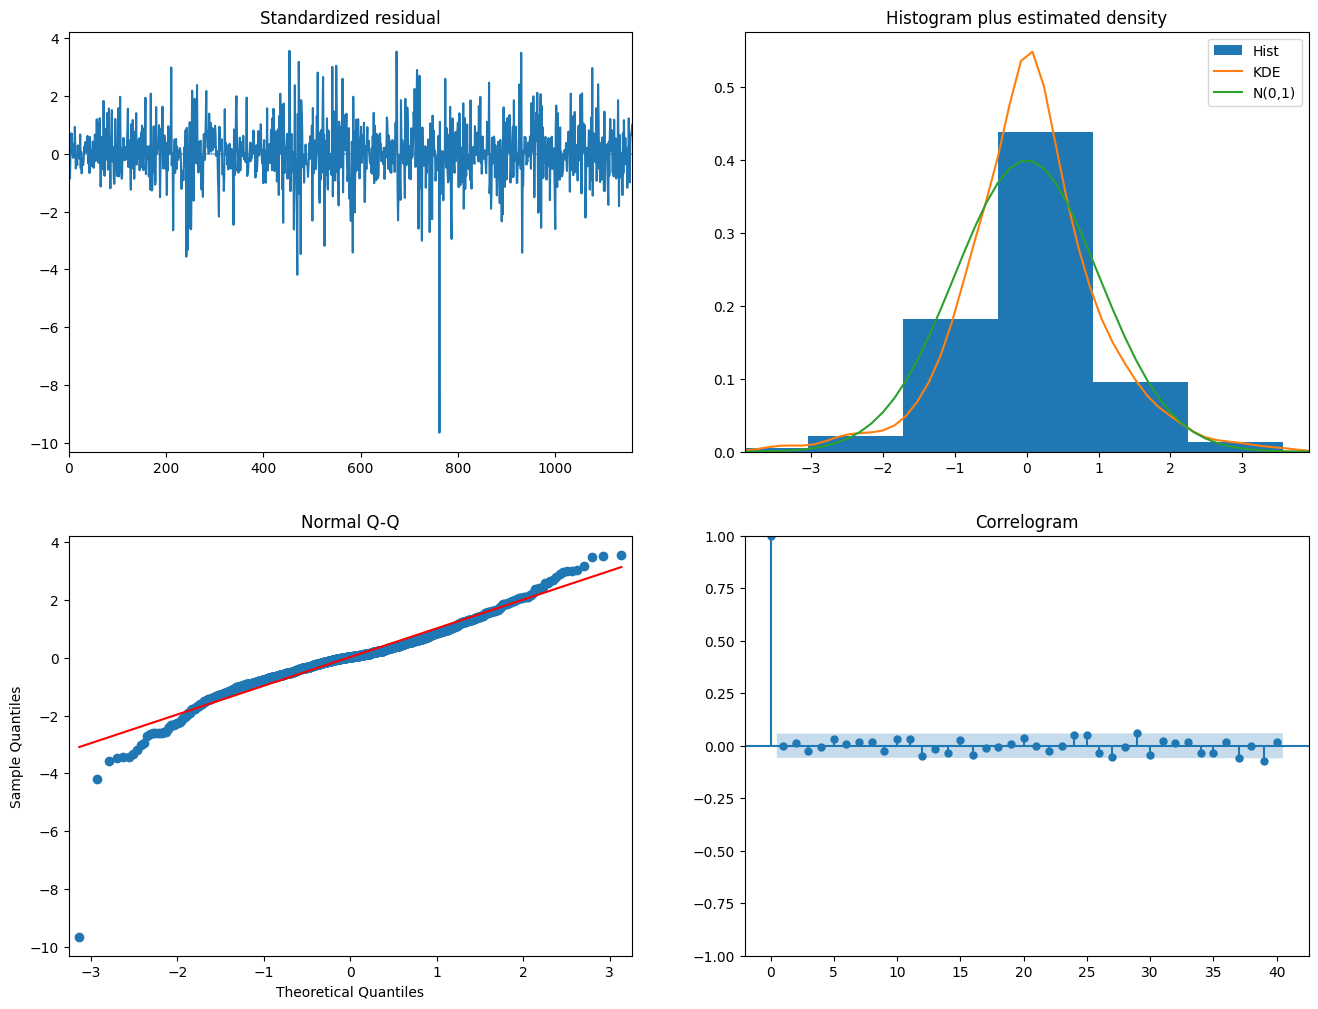

Stock of VNM
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19820.859, Time=1.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19824.073, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19826.064, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19826.068, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19829.039, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19828.892, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19822.892, Time=1.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19828.064, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19828.243, Time=1.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19827.778, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19824.855, Time=0.85 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19822.181, Time=2.30 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 10.453 seconds
 

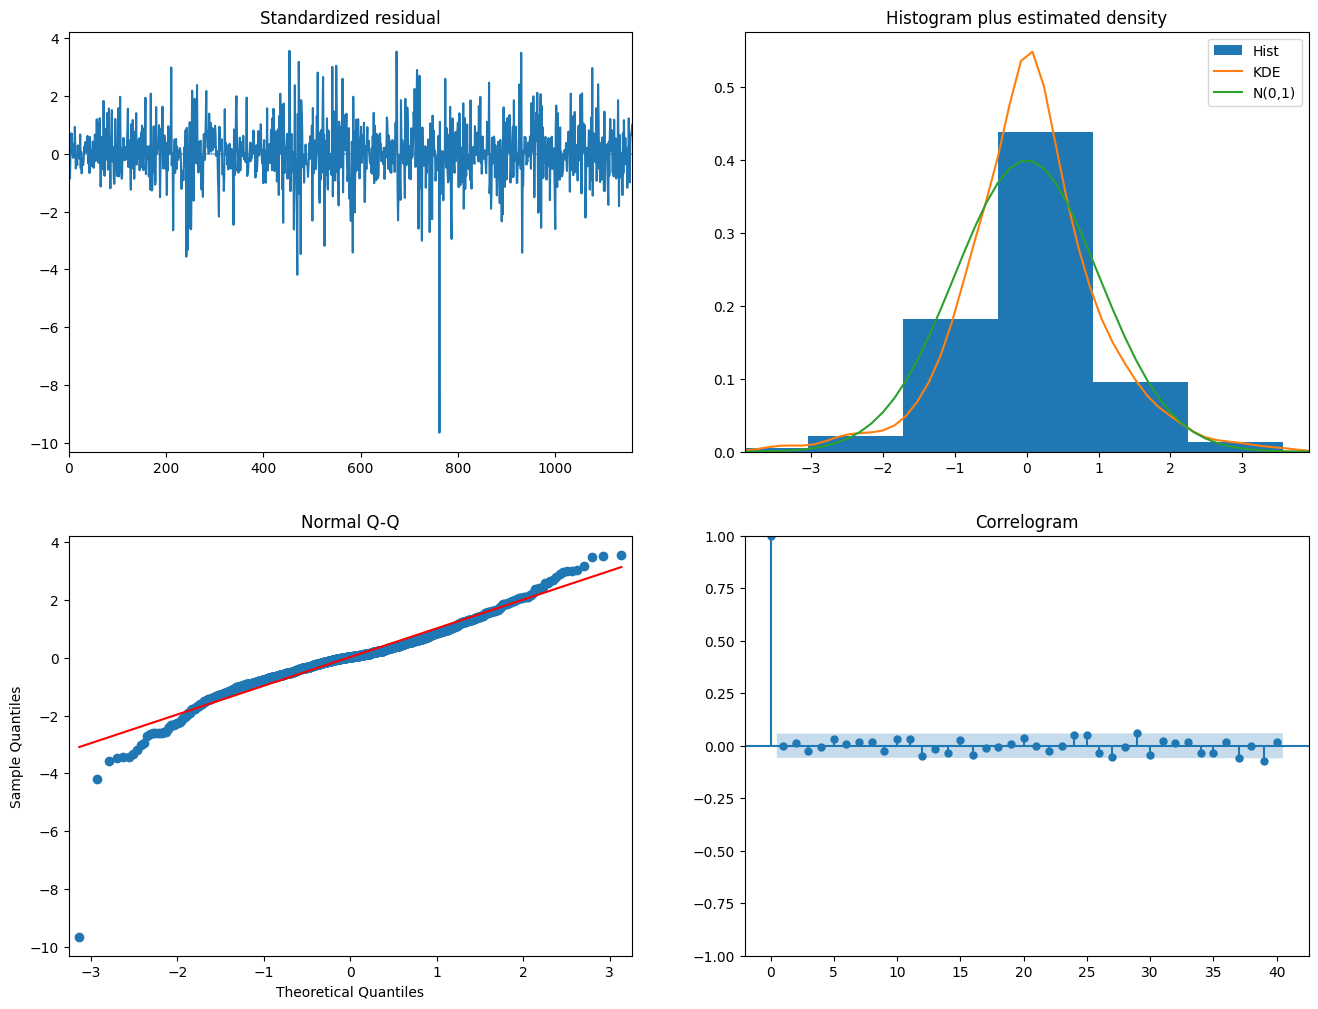

Stock of VCB
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19820.859, Time=1.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19824.073, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19826.064, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19826.068, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19829.039, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19828.892, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19822.892, Time=1.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19828.064, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19828.243, Time=0.69 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19827.778, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19824.855, Time=0.87 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19822.181, Time=2.56 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 10.261 seconds
 

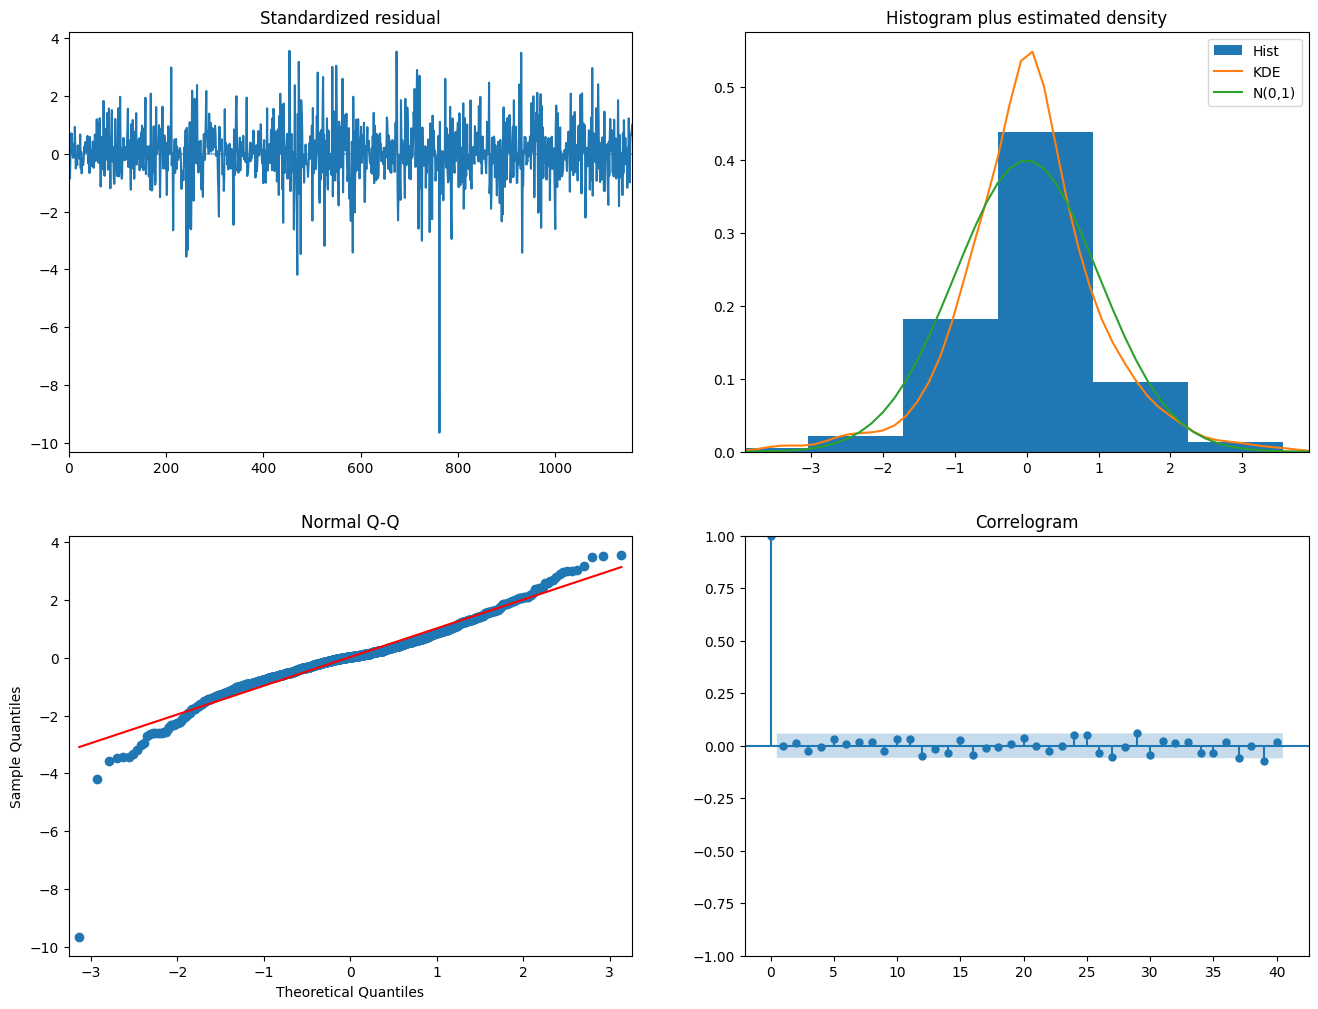


 Performance model:
           MSE    MAE    R2
FPT 843,670.17 642.43 -0.01
HPG 843,670.17 642.43 -0.01
MWG 843,670.17 642.43 -0.01
VNM 843,670.17 642.43 -0.01
VCB 843,670.17 642.43 -0.01


In [60]:
results_arima = {}
for company, data in stocks.items():
    print(f'Stock of {company}')
    metrics = training_arima(value['Price diff'])
    results_arima[company] = {'Model': metrics[0], 'MSE': metrics[1], 'MAE': metrics[2], 'R2': metrics[3]}

arima_result_df = pd.DataFrame(results_arima).T 
print('\n Performance model:')
print(arima_result_df[['MSE', 'MAE', 'R2']])

## LSTM

In [61]:
def create_sequences(data, time_steps, target):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i +time_steps, :])
        y.append(data[i + time_steps, target])
    return np.array(X), np.array(y)

def training_LSTM(data, features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features + ['Target']])
    
    time_steps = 60 
    target = -1
    X, y = create_sequences(scaled_data, time_steps, target)
    y = y.reshape(-1, 1)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32),
        # Dropout(0.2),
        # Dense(units=16),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stop = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
    
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop]
    )
    
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Training loss: {train_loss:.4f}, Testing loss: {test_loss:.4f}")
    
    y_pred = model.predict(X_test)
    y_pred_extended = np.zeros((len(y_pred), scaled_data.shape[1]))
    y_pred_extended[:, -1] = y_pred.reshape(-1)
    y_pred_unscaled = scaler.inverse_transform(y_pred_extended)[:, -1]
    
    y_test_extended = np.zeros((len(y_test), scaled_data.shape[1]))
    y_test_extended[:, -1] = y_test.reshape(-1)
    y_test_unscaled = scaler.inverse_transform(y_test_extended)[:, -1]
    test_dates = data.index[-len(y_test_unscaled):]
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
    return [model, mae, mse, r2, y_test_unscaled, y_pred_unscaled, test_dates]

In [62]:
results_LSTM = {}
for company, data in stocks.items():
    data = data.drop(columns=['Price diff'])
    features = ['Change %', 'MACD', 'RSI', 'OBV',
            'PSAR', 'SMA_10', 'SMA_50', 'EMA_50']
    metrics = training_LSTM(data, features)
    results_LSTM[company] = {
        'Model': metrics[0], 
        'MAE': metrics[1],
        'MSE':metrics[2],
        'R2':metrics[3],
        'Actual':metrics[4],
        'Predict':metrics[5],
        'Test date': metrics[6]
    }
    
LSTM_result_df = pd.DataFrame(results_LSTM).T
print("Performance model:")
print(LSTM_result_df[['MAE', 'MSE', 'R2']]) 

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0274 - val_loss: 0.0358
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0017 - val_loss: 0.0242
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0014 - val_loss: 0.0195
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 9.4318e-04 - val_loss: 0.0296
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 8.4843e-04 - val_loss: 0.0344
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0010 - val_loss: 0.0310
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 9.7274e-04 - val_loss: 0.0386
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 8.0247e-04 - val_loss: 0.0441
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
Training loss: 0.0008, Testing loss: 0.0195
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0376 - val_loss: 9.5214e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 97

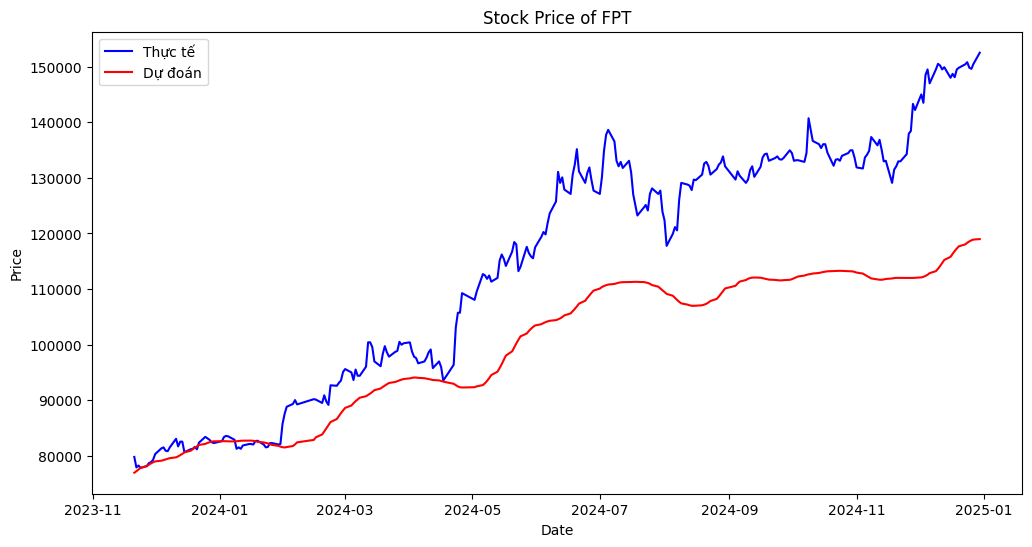

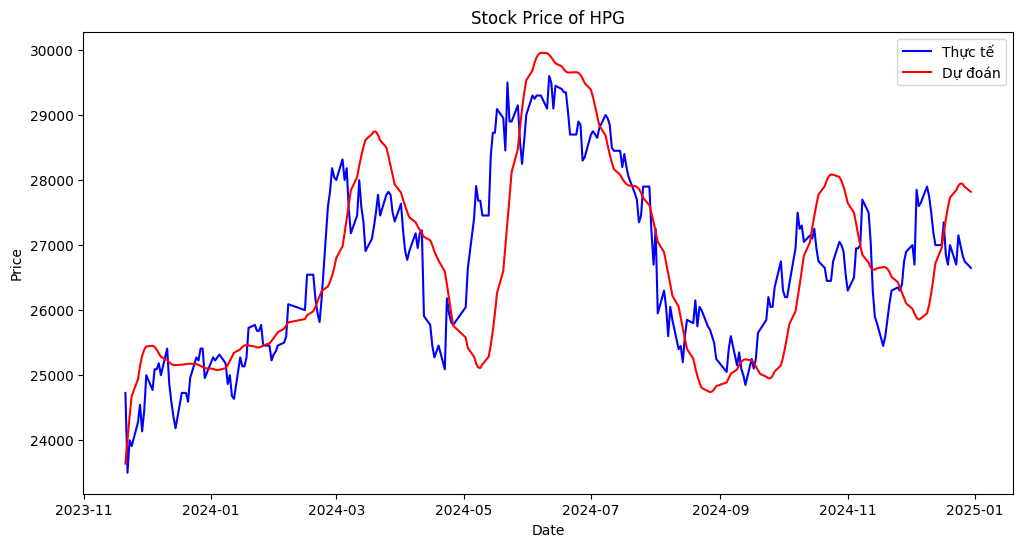

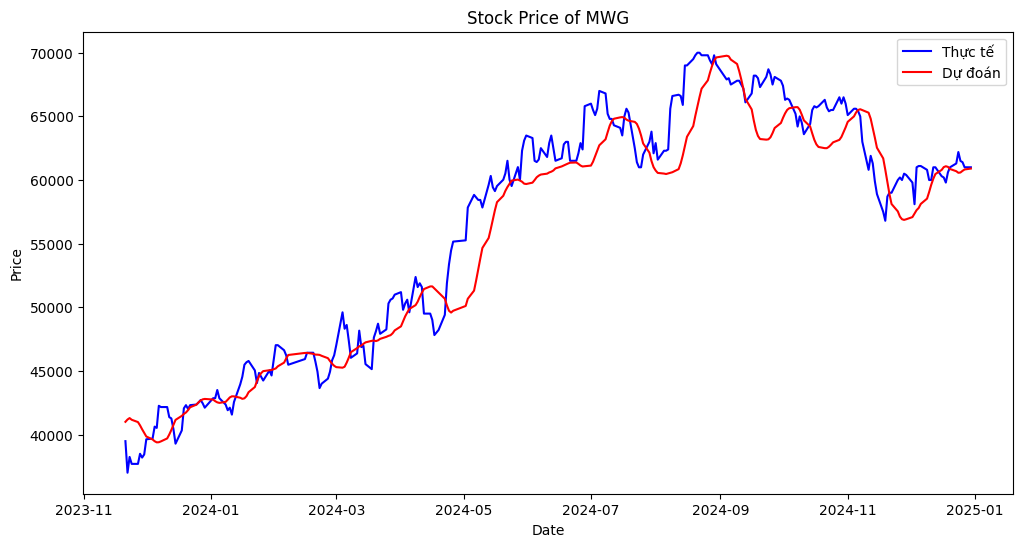

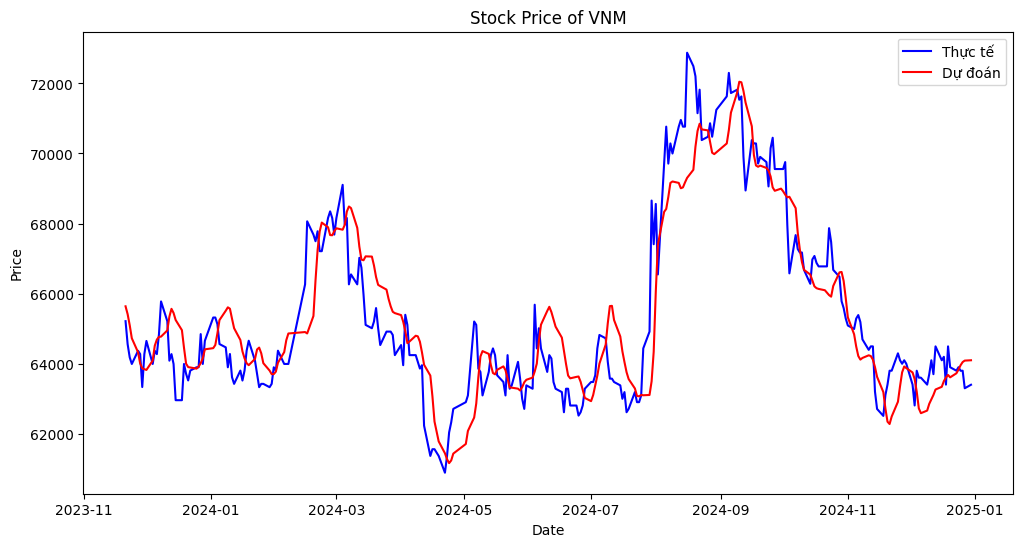

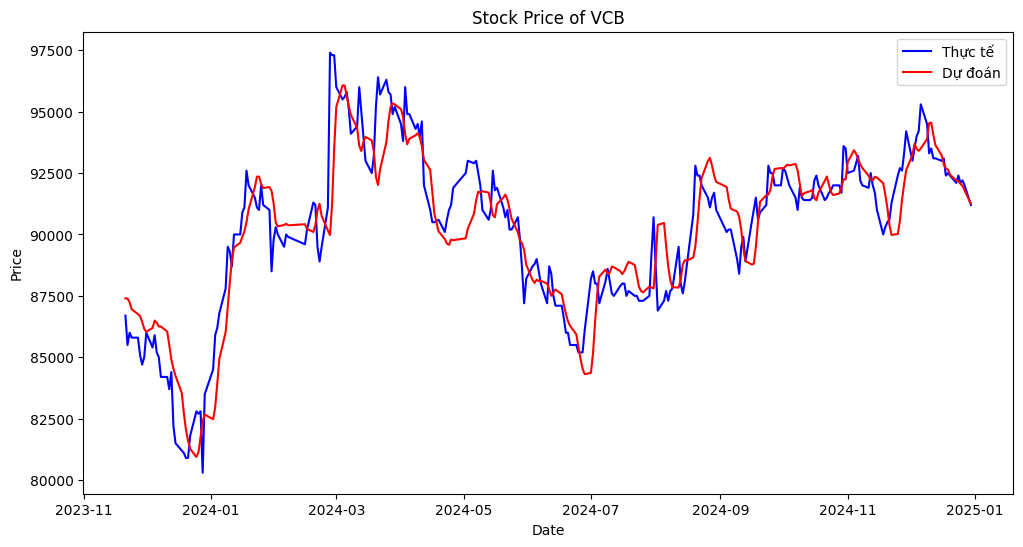

In [63]:

for company, data in results_LSTM.items():
    # size = int(0.8 * len(stocks[company]))
    # dates = stocks[company].iloc[size:].index
    plt.figure(figsize=(12, 6))
    plt.plot(data['Test date'], data["Actual"], label="Thực tế", color="blue")
    plt.plot(data['Test date'], data["Predict"], label="Dự đoán", color="red")
    plt.legend()
    plt.title(f"Stock Price of {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()  

## Conclusion

In [64]:
total_result = {
    'Linear Regression': results_df[['MSE', 'MAE', 'R2']],
    'ARIMA': arima_result_df[['MSE', 'MAE', 'R2']],
    'LSTM': LSTM_result_df[['MSE', 'MAE', 'R2']]
}
for model, indicator in total_result.items():
    print(f'Performance model {key}')
    print(indicator)

Performance model VCB
             MSE      MAE   R2
FPT 4,781,263.68 1,571.77 0.99
HPG   186,616.88   334.35 0.91
MWG 1,356,319.13   911.57 0.99
VNM   798,150.70   675.26 0.88
VCB 1,258,875.38   838.10 0.89
Performance model VCB
           MSE    MAE    R2
FPT 843,670.17 642.43 -0.01
HPG 843,670.17 642.43 -0.01
MWG 843,670.17 642.43 -0.01
VNM 843,670.17 642.43 -0.01
VCB 843,670.17 642.43 -0.01
Performance model VCB
               MSE       MAE   R2
FPT 325,451,235.07 14,862.09 0.35
HPG     862,486.92    716.46 0.55
MWG   6,297,248.76  1,949.52 0.93
VNM   1,244,413.76    866.15 0.82
VCB   2,029,734.06  1,060.13 0.82


Từ bảng so sánh trên, Linear Regression model có MSE, MAE thấp nhất và R2 cao nhất.  

In [65]:
models = {}
for key, value in results.items():
    models[key] = value['model']
    
jb.dump(models, r'C:\Users\user\Documents\python\Project Stock\Linear model trained.pkl')

['C:\\Users\\user\\Documents\\python\\Project Stock\\Linear model trained.pkl']